# GoT emotion mining

### The project is divided into two parts:
- The first part is an exploratory analysis of the Game of Thrones corpus. Different word frequency related questions about the characters of the TV series were answered.
 
 
 
- The second part is the main focus of the project. More precisely, it is the emotion mining part, where multiple different annotated datasets are reviewed, combined and preprocessed in order to create a training set to be used for the machine learning and deep learning algorithms. Different numerical representations, TF-IDF and word embeddings, are used and the models that are compared are Multinomial Naive Bayes, Support Vector Machines and Bi-directional LSTMs. 



In [1]:
import re, string
import json
from collections import Counter
import pdb

import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import toyplot
import spacy
nlp = spacy.load("en_core_web_sm")

#import seaborn as sns

#import num2words

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download(["stopwords", "vader_lexicon", "punkt", "wordnet", "averaged_perceptron_tagger"])

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

import sklearn
from sklearn.metrics import cohen_kappa_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

import altair as alt

data_folder = 'data/'
img_folder = 'img/'

embedding_dim = 300
MAX_NB_WORDS = 40000


# Loading GloVe to memory as a dictionary
embeddings_index = dict()
f = open('glove.840B.300d.txt', 'r', errors = 'ignore', encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#########################################################################################################
#########################################################################################################

# For plotting a custom confusion matrix

class_names = ["other", "anger", "disgust", "fear", "joy", "sadness", "surprise"]

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
      
    title = 'Normalized confusion matrix'        

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using TensorFlow backend.


<br>

# Part 1: Exploratory analysis of the corpus

In [64]:
# Loading the data
data= pd.read_csv(data_folder + "got_scripts_breakdown.csv", delimiter=';')
data.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,"What d’you expect? They’re savages One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces",waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,"I’ve never seen wildlings do a thing like this I’ve never seen a thing like this, not ever in my life",will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [74]:
data['Season'] = data['Season'].astype(int)

In [8]:
# Removing unnecessary columns
data = data.drop(['Column1', 'Emision Date', 'Episode', 'N_Season','N_serie'], axis = 1) 

# Turning everything to lowercase
data["Sentence"] = data["Sentence"].str.lower()                                           

df1 = data.copy(deep=True) 
df2 = data.copy(deep=True) 
df3 = data.copy(deep=True) 

data.head()

,Season,Sentence,Name
0,Season 1,"what d’you expect? they’re savages one lot steals a goat from another lot and before you know it, they’re ripping each other to pieces",waymar royce
1,Season 1,"i’ve never seen wildlings do a thing like this i’ve never seen a thing like this, not ever in my life",will
2,Season 1,how close did you get?,waymar royce
3,Season 1,close as any man would,will
4,Season 1,we should head back to the wall,gared


In [9]:
data.shape

(22510, 3)

In [10]:
## Checking the 40 most commonly used words in the text
Counter(" ".join(data["Sentence"]).split()).most_common(40)

[('the', 12153),
 ('you', 9557),
 ('to', 7850),
 ('i', 7385),
 ('a', 6107),
 ('and', 5294),
 ('of', 4502),
 ('your', 3284),
 ('my', 3159),
 ('in', 2619),
 ('is', 2618),
 ('it', 2585),
 ('for', 2484),
 ('me', 2352),
 ('he', 2234),
 ('have', 2165),
 ('that', 2097),
 ('not', 1894),
 ('we', 1884),
 ('be', 1757),
 ('what', 1733),
 ('do', 1659),
 ('was', 1625),
 ('are', 1625),
 ('with', 1605),
 ('will', 1496),
 ('they', 1395),
 ('but', 1342),
 ('if', 1330),
 ('his', 1325),
 ('this', 1323),
 ('all', 1286),
 ('no', 1284),
 ('him', 1253),
 ('on', 1198),
 ('her', 1195),
 ('know', 1131),
 ('them', 1074),
 ('dont', 1033),
 ('one', 1031)]

In [12]:
# The NLTK library offers a predefined list of stopwords

stopwords = nltk.corpus.stopwords.words("english")
print(stopwords)
print()
print("Total number of stopwords is:" + " " + str(len(stopwords)))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Preprocessing

Different preprocessing will be conducted for the two tasks. For the emotion analysis part, a different preprocessing approach will be followed since the removal of specific words can greatly affect the semantic value of each sentence. Nevertheless, for the first task, which mainly focuses on word frequencies, very frequently used words like articles, pronouns, prepositions, and conjunctions can be removed. The overall preprocessing consists of the following steps:
- Removing of punctuation
- Removing of stopwords
- Conversion to lowercase
- Lemmatization

In order to provide a more basic form for the words, lemmatization was prefered over stemming. The reason for this is that lemmatization is considered as a more effective way, as it reduces variant forms to their base form, while stemming cuts the prefixes and suffixes of words, which can lead to the creation of words that do not exist. 

The first approach that was tested is NLTK's pretrained lemmatizer, however the results obtained where not satisfying enough as there were many cases where the words were not converted into their roots, for instance, "wildlinks", "seen", "killed" etc. A different approach was then tested, more precisely, the same lemmatizer was used but POS tagging was performed firstly, which proved to improve the results significantly. However, there were still cases were the results were not good enough. Spacy is another library, with a different pretrained lemmatizer that turned out to produce much better results, consequently, it was decided to proceed with using this one. The reason for this is that it also performs the POS tagging automatically, while it follows a different set of rules to return the words into their root.

In [13]:
def preprocessing_freq(sentence):
    # remove punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]
    sentence = ''.join(nopunc)
    
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords]) 
    
    # lemmatization
    doc = nlp(sentence)
    sentence = [token.lemma_ if ('PRON' not in token.lemma_) & (len(token.lemma_) > 2) else '' for token in doc]
    sentence = ' '.join([word for word in sentence]) 
    
    return sentence

In [14]:
data["Sentence"] = data.Sentence.apply(preprocessing_freq)
data.head(20)

,Season,Sentence,Name
0,Season 1,d’you expect they ’re savage one lot steal goat another lot know they ’re rip piece,waymar royce
1,Season 1,’ve never see wildling thing like ’ve never see thing like ever life,will
2,Season 1,close get,waymar royce
3,Season 1,close man would,will
4,Season 1,head back wall,gared
5,Season 1,dead frighten,royce
6,Season 1,order track wildling track n’t trouble,gared
7,Season 1,n’t think ’ll ask die get back horse,royce
8,Season 1,whatever could even kill child,will
9,Season 1,good thing ’re child want run away south run away course behead deserter n’t catch first get back horse n’t say,royce


In [15]:
# After the removal of the stopwords, some very short sentences, constisting of only stopwords, are now empty,
# thus these lines will be removed.

data = data[(data['Sentence'] != '') & (data['Sentence'] != ' ')]
data.head(20)

,Season,Sentence,Name
0,Season 1,d’you expect they ’re savage one lot steal goat another lot know they ’re rip piece,waymar royce
1,Season 1,’ve never see wildling thing like ’ve never see thing like ever life,will
2,Season 1,close get,waymar royce
3,Season 1,close man would,will
4,Season 1,head back wall,gared
5,Season 1,dead frighten,royce
6,Season 1,order track wildling track n’t trouble,gared
7,Season 1,n’t think ’ll ask die get back horse,royce
8,Season 1,whatever could even kill child,will
9,Season 1,good thing ’re child want run away south run away course behead deserter n’t catch first get back horse n’t say,royce


In [16]:
data.shape # 1047 lines were removed

(21463, 3)

## At this point, the previsouly mentioned comparison of the different lemmatizers is illustrated.

In [17]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def punctuation(sentence):
    # remove punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]
    sentence = ''.join(nopunc)
    
    return sentence
   
    # remove stopwords

def stop_words(sentence):    
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords]) 
    
    return sentence

def lemmatization(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

In [18]:
df1['Sentence'] = df1.Sentence.apply(punctuation)
df1['Sentence'] = df1.Sentence.apply(stop_words)
df1['Sentence'] = df1.Sentence.apply(lemmatization)
df1.head(10)

,Season,Sentence,Name
0,Season 1,"[d’you, expect, they’re, savage, one, lot, steal, goat, another, lot, know, they’re, ripping, piece]",waymar royce
1,Season 1,"[i’ve, never, seen, wildlings, thing, like, i’ve, never, seen, thing, like, ever, life]",will
2,Season 1,"[close, get]",waymar royce
3,Season 1,"[close, man, would]",will
4,Season 1,"[head, back, wall]",gared
5,Season 1,"[dead, frighten]",royce
6,Season 1,"[order, track, wildlings, tracked, won’t, trouble, u]",gared
7,Season 1,"[don’t, think, he’ll, ask, u, died, get, back, horse]",royce
8,Season 1,"[whatever, could, u, even, killed, child]",will
9,Season 1,"[it’s, good, thing, we’re, child, want, run, away, south, run, away, course, behead, deserter, don’t, catch, first, get, back, horse, won’t, say]",royce


#### As can be observed, the results are not satisfying at all, as there are many cases where the words are not converted into their roots, for instance, "wildlinks", "seen", "killed" etc. A different approach was tested, more precisely POS tagging was performed first and that proved to improve the results comparing to the first approach.

In [19]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatization2(text):
    
    return [lemmatizer.lemmatize(w , get_wordnet_pos(w)) for w in tokenizer.tokenize(text)]

In [20]:
df2['Sentence'] = df2.Sentence.apply(punctuation)
df2['Sentence'] = df2.Sentence.apply(stop_words)
df2['Sentence'] = df2.Sentence.apply(lemmatization2)
df2.head(10)

,Season,Sentence,Name
0,Season 1,"[d’you, expect, they’re, savage, one, lot, steal, goat, another, lot, know, they’re, rip, piece]",waymar royce
1,Season 1,"[i’ve, never, see, wildlings, thing, like, i’ve, never, see, thing, like, ever, life]",will
2,Season 1,"[close, get]",waymar royce
3,Season 1,"[close, man, would]",will
4,Season 1,"[head, back, wall]",gared
5,Season 1,"[dead, frighten]",royce
6,Season 1,"[order, track, wildlings, tracked, won’t, trouble, u]",gared
7,Season 1,"[don’t, think, he’ll, ask, u, die, get, back, horse]",royce
8,Season 1,"[whatever, could, u, even, kill, child]",will
9,Season 1,"[it’s, good, thing, we’re, child, want, run, away, south, run, away, course, behead, deserter, don’t, catch, first, get, back, horse, won’t, say]",royce


#### However, the results obtained are not satisfying enough, thus an alternative approach was also tested. Spacy is another library that turned out to produce much better results, consequently, it was decided to proceed with using this one.

In [21]:
def lemmatization3(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])
    #return [token.lemma_ for token in doc]

In [22]:
df3['Sentence'] = df3.Sentence.apply(punctuation)
df3['Sentence'] = df3.Sentence.apply(stop_words)
df3['Sentence'] = df3.Sentence.apply(lemmatization3)
df3.head(10)

,Season,Sentence,Name
0,Season 1,d’you expect they ’re savage one lot steal goat another lot know they ’re rip piece,waymar royce
1,Season 1,I ’ve never see wildling thing like I ’ve never see thing like ever life,will
2,Season 1,close get,waymar royce
3,Season 1,close man would,will
4,Season 1,head back wall,gared
5,Season 1,dead frighten,royce
6,Season 1,order track wildling track wo n’t trouble we,gared
7,Season 1,do n’t think he ’ll ask we die get back horse,royce
8,Season 1,whatever could we even kill child,will
9,Season 1,it ’ good thing we ’re child want run away south run away course behead deserter do n’t catch first get back horse wo n’t say,royce


### Getting the houses of the main characters

Having completed the preprocessing of the text, the main characters will now be separated into houses. In order to perfomr the division, the relevant information was located on the web and dowloaded as a json file.

In [23]:
with open('GOT_houses.json') as json_file:
    houses = json.load(json_file)

In [24]:
print(houses)

{'groups': [{'name': 'Stark', 'characters': ['Arya Stark', 'Benjen Stark', 'Bran Stark', 'Catelyn Stark', 'Eddard Stark', 'Ghost', 'Grey Wind', 'Jon Snow', 'Lady', 'Nymeria', 'Rickon Stark', 'Robb Stark', 'Sansa Stark', 'Shaggydog', 'Summer']}, {'name': 'Targaryen', 'characters': ['Daenerys Targaryen', 'Drogon', 'Rhaegal', 'Viserion', 'Viserys Targaryen']}, {'name': 'Baratheon', 'characters': ['Joffrey Baratheon', 'Myrcella Baratheon', 'Renly Baratheon', 'Robert Baratheon', 'Selyse Baratheon', 'Shireen Baratheon', 'Stannis Baratheon', 'Tommen Baratheon', 'Gendry']}, {'name': 'Lannister', 'characters': ['Cersei Lannister', 'Jaime Lannister', 'Kevan Lannister', 'Lancel Lannister', 'Tyrion Lannister', 'Tywin Lannister']}, {'name': "Night's Watch", 'characters': ['Alliser Thorne', 'Eddison Tollett', 'Grenn', 'Jeor Mormont', 'Karl Tanner', 'Maester Aemon', 'Olly', 'Othell Yarwyck', 'Pypar', 'Qhorin Halfhand', 'Rast', 'Samwell Tarly', 'Yoren']}, {'name': 'Dothraki', 'characters': ['Doreah', 

In [25]:
names = []

for house in houses['groups']:
    for key, value in house.items():
         if key == "characters":
            names.append(value)

In [26]:
names

[['Arya Stark',
  'Benjen Stark',
  'Bran Stark',
  'Catelyn Stark',
  'Eddard Stark',
  'Ghost',
  'Grey Wind',
  'Jon Snow',
  'Lady',
  'Nymeria',
  'Rickon Stark',
  'Robb Stark',
  'Sansa Stark',
  'Shaggydog',
  'Summer'],
 ['Daenerys Targaryen', 'Drogon', 'Rhaegal', 'Viserion', 'Viserys Targaryen'],
 ['Joffrey Baratheon',
  'Myrcella Baratheon',
  'Renly Baratheon',
  'Robert Baratheon',
  'Selyse Baratheon',
  'Shireen Baratheon',
  'Stannis Baratheon',
  'Tommen Baratheon',
  'Gendry'],
 ['Cersei Lannister',
  'Jaime Lannister',
  'Kevan Lannister',
  'Lancel Lannister',
  'Tyrion Lannister',
  'Tywin Lannister'],
 ['Alliser Thorne',
  'Eddison Tollett',
  'Grenn',
  'Jeor Mormont',
  'Karl Tanner',
  'Maester Aemon',
  'Olly',
  'Othell Yarwyck',
  'Pypar',
  'Qhorin Halfhand',
  'Rast',
  'Samwell Tarly',
  'Yoren'],
 ['Doreah', 'Irri', 'Khal Drogo', 'Rakharo', 'Qhono'],
 ['Balon Greyjoy', 'Euron Greyjoy', 'Theon Greyjoy', 'Yara Greyjoy'],
 ['Loras Tyrell', 'Mace Tyrell', 'M

In [27]:
# There are 154 characters in the list

counter=0
for i in names:
    for j in i:
        counter = counter+1
counter

154

In [28]:
fullnames = []

# Not all 154 characters will be used. The focus will be on those bellonging to the main houses.

main_houses = ['Stark','Lannister','Baratheon','Targaryen','Greyjoy']

for house in houses['groups']:
    for character in house['characters']:
        curr_character = []
        
        if house['name'] in main_houses:
#             for itemx in character.split(' '):
#                 curr_character.append(itemx)

            curr_character.append(character.split(' ')[0].lower())
            
            curr_character.append(house['name'])

            fullnames.append(curr_character)

In [29]:
fullnames[0][0].title()

'Arya'

In [30]:
fullnames

[['arya', 'Stark'],
 ['benjen', 'Stark'],
 ['bran', 'Stark'],
 ['catelyn', 'Stark'],
 ['eddard', 'Stark'],
 ['ghost', 'Stark'],
 ['grey', 'Stark'],
 ['jon', 'Stark'],
 ['lady', 'Stark'],
 ['nymeria', 'Stark'],
 ['rickon', 'Stark'],
 ['robb', 'Stark'],
 ['sansa', 'Stark'],
 ['shaggydog', 'Stark'],
 ['summer', 'Stark'],
 ['daenerys', 'Targaryen'],
 ['drogon', 'Targaryen'],
 ['rhaegal', 'Targaryen'],
 ['viserion', 'Targaryen'],
 ['viserys', 'Targaryen'],
 ['joffrey', 'Baratheon'],
 ['myrcella', 'Baratheon'],
 ['renly', 'Baratheon'],
 ['robert', 'Baratheon'],
 ['selyse', 'Baratheon'],
 ['shireen', 'Baratheon'],
 ['stannis', 'Baratheon'],
 ['tommen', 'Baratheon'],
 ['gendry', 'Baratheon'],
 ['cersei', 'Lannister'],
 ['jaime', 'Lannister'],
 ['kevan', 'Lannister'],
 ['lancel', 'Lannister'],
 ['tyrion', 'Lannister'],
 ['tywin', 'Lannister'],
 ['balon', 'Greyjoy'],
 ['euron', 'Greyjoy'],
 ['theon', 'Greyjoy'],
 ['yara', 'Greyjoy']]

In [31]:
# The array isconverted into a dataframe in order to merge it with the existing dataset.

fullnames = pd.DataFrame(fullnames, columns = ['Name', 'House'])

In [32]:
fullnames.head()

,Name,House
0,arya,Stark
1,benjen,Stark
2,bran,Stark
3,catelyn,Stark
4,eddard,Stark


In [33]:
# A new column was added, indicating the house that every character belongs to.

df = data.merge(fullnames, on='Name')#, how='left')
df.head()

,Season,Sentence,Name,House
0,Season 1,father watch,jon,Stark
1,Season 1,mother,jon,Stark
2,Season 1,n’t think much bran,jon,Stark
3,Season 1,n’t look away,jon,Stark
4,Season 1,father know,jon,Stark


In [34]:
graph = fullnames.drop_duplicates(subset=['Name'], keep=False)
graph

,Name,House
0,arya,Stark
1,benjen,Stark
2,bran,Stark
3,catelyn,Stark
4,eddard,Stark
5,ghost,Stark
6,grey,Stark
7,jon,Stark
8,lady,Stark
9,nymeria,Stark


In [35]:
# A visualization of the division of the main characters into their respective houses.

layout = toyplot.layout.FruchtermanReingold(edges=toyplot.layout.CurvedEdges())

edges = np.array([["balon", "Greyjoy"], ["euron", "Greyjoy"], ["theon", "Greyjoy"], ["yara", "Greyjoy"], 
                  ["cersei", "Lannister"], ["jaime", "Lannister"], ["tywin", "Lannister"], ["tyrion", "Lannister"], ["kevan", "Lannister"], ["lancel", "Lannister"],
                  ["stannis", "Baratheon"], ["tommen", "Baratheon"], ["joffrey", "Baratheon"], ["myrcella", "Baratheon"], ["renly", "Baratheon"], ["robert", "Baratheon"], ["gendry", "Baratheon"], ["shireen", "Baratheon"], ["selyse", "Baratheon"],
                  ["daenerys", "Targaryen"], ["drogon  ", "Targaryen"], ["rhaegal ", "Targaryen"], ["viserion  ", "Targaryen"], ["viserys ", "Targaryen"],
                  ["arya", "Stark"], ["benjen", "Stark"], ["bran", "Stark"], ["catelyn", "Stark"], ["eddard", "Stark"], ["jon", "Stark"], ["rickon", "Stark"], ["robb", "Stark"], ["sansa", "Stark"], ["ned", "Stark"]])

toyplot.graph(edges, margin = 35, layout = layout, ewidth = 3, vsize = 10, width = 675)

(<toyplot.canvas.Canvas at 0x216b46c74f0>,
 <toyplot.mark.Graph at 0x216b470d5b0>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="675.0px" height="675.0px" viewBox="0 0 675.0 675.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tba50b9ec767449fb88d547bbf00376f6"> Baratheon Greyjoy Lannister Stark Targaryen arya balon benjen bran catelyn cersei daenerys drogon eddard euron gendry jaime joffrey jon kevan lancel myrcella ned renly rhaegal rickon robb robert sansa selyse shireen stannis theon tommen tyrion tywin viserion viserys yara

### Generation of wordclouds for the most frequently spoken words of each house

In [36]:
def wordclouds(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='RdYlGn',
                      mask=mask,
                      background_color='white',
                      #stopwords=stopwords,
                      collocations=True,
                      contour_color='#5d0f24',
                      contour_width=0.01).generate_from_text(data)
    plt.figure(figsize=(16,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

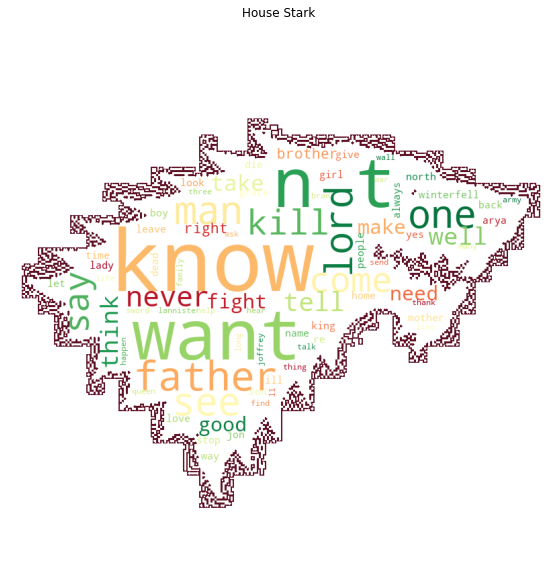

In [38]:
stark_quotes = ""
stark_mask = np.array(Image.open(img_folder + 'starks1.jpg'))

for sentence in df.loc[df['House'] == 'Stark']['Sentence']:
    stark_quotes = stark_quotes + ' ' + sentence
           
wordclouds(stark_quotes, 'House Stark', mask = stark_mask)

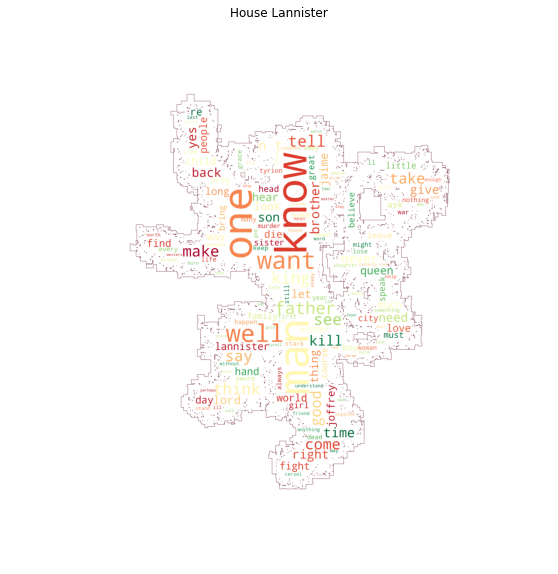

In [39]:
lannister_quotes = ""
lannister_mask = np.array(Image.open(img_folder + 'lannister1.jpg'))

for sentence in df.loc[df['House'] == 'Lannister']['Sentence']:
    lannister_quotes = lannister_quotes + ' ' + sentence
           
wordclouds(lannister_quotes, 'House Lannister', mask = lannister_mask)

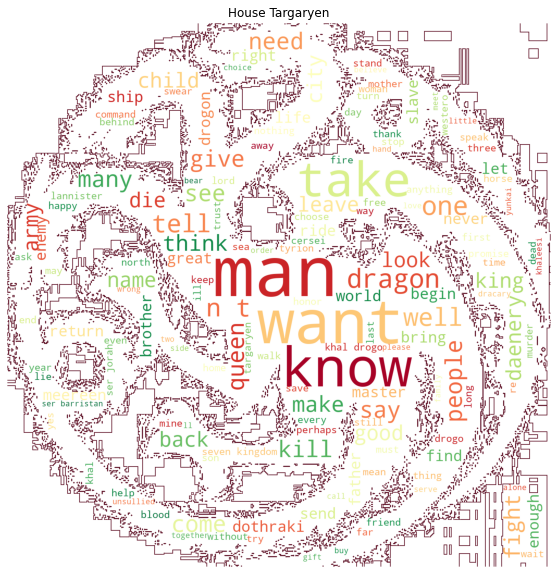

In [40]:
targaryen_quotes = ""
targaryen_mask = np.array(Image.open(img_folder + 'targaryen.jpg'))

for sentence in df.loc[df['House'] == 'Targaryen']['Sentence']:
    targaryen_quotes = targaryen_quotes + ' ' + sentence
           
wordclouds(targaryen_quotes, 'House Targaryen', mask = targaryen_mask)

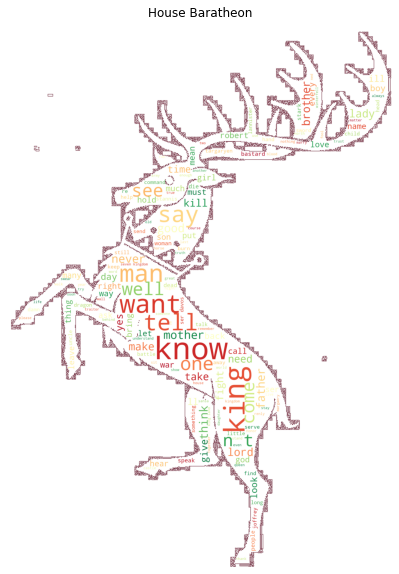

In [41]:
baratheon_quotes = ""
baratheon_mask = np.array(Image.open(img_folder + 'baratheon4.jpg'))

for sentence in df.loc[df['House'] == 'Baratheon']['Sentence']:
    baratheon_quotes = baratheon_quotes + ' ' + sentence
           
wordclouds(baratheon_quotes, 'House Baratheon', mask = baratheon_mask)

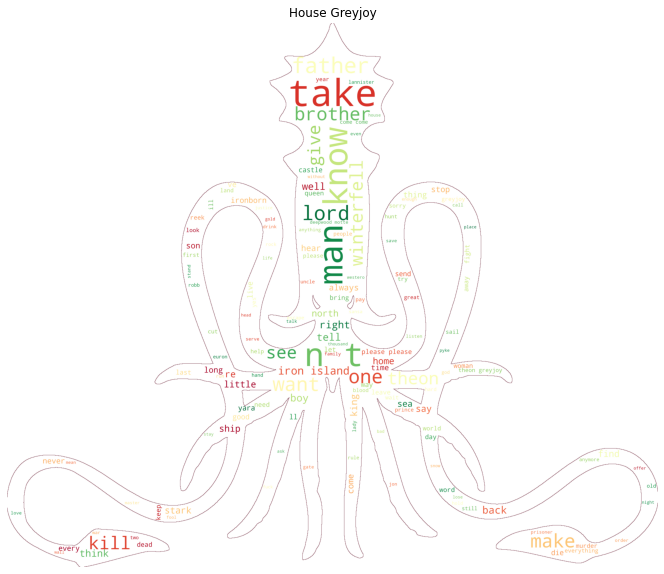

In [42]:
greyjoy_quotes = ""
greyjoy_mask = np.array(Image.open(img_folder + 'greyjoy.png'))

for sentence in df.loc[df['House'] == 'Greyjoy']['Sentence']:
    greyjoy_quotes = greyjoy_quotes + ' ' + sentence
           
wordclouds(greyjoy_quotes, 'House Greyjoy', mask = greyjoy_mask)

### Character comparison based on the vocabulary they use

##### - Firstly, Daenerys and Cersei are compared in terms of how often they use the words: "love", "kill", "war", "throne", "enemy", "queen".
In general, Danaerys could be described as a gentle and mild character, while Cersei is cruel, violent and among the least pleasant characters of the series. Surprisingly and contrary to the general perception, Danaerys uses the world "kill" more frequently than Cersei, while the latter uses the word "love" much more frequently.


##### - Afterwards, Jon and Tyrion are compared on the wordlist: "north", "love", "kill", "war", "throne", "queen".
Jon is a fighter, while Tyrion is a mastermind that is rarely involved into fighting. However, Tyrion uses the words "kill" and "war" more frequently than Jon, who is always at war, and also talks more about the throne, even though Jon eventually becomes the king.

In [48]:
words = ["love", "kill", "war", "throne", "enemy", "queen"] 

In [49]:
daenerys = df[df['Name'] == 'daenerys']['Sentence']
daenerys = pd.Series(' '.join(daenerys).split()).value_counts().reset_index().rename(columns={'index':'word', 0:'Daenerys'})
daenerys = daenerys[daenerys.word.isin(words)]

In [50]:
cersei = df[df['Name'] == 'cersei']['Sentence']
cersei = pd.Series(' '.join(cersei).split()).value_counts().reset_index().rename(columns={'index':'word', 0:'Cersei'})
cersei = cersei[cersei.word.isin(words)]

<AxesSubplot:ylabel='frequency'>

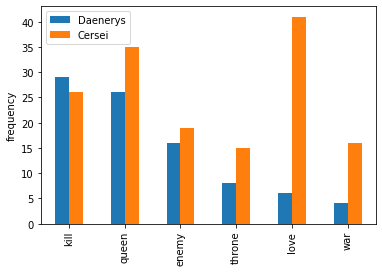

In [51]:
daenerys.merge(cersei, on='word').set_index('word').plot(kind='bar', xlabel='', ylabel='frequency')

In [52]:
words1 = ["north", "love", "kill", "war", "throne", "queen"] 

In [53]:
jon = df[df['Name'] == 'jon']['Sentence']
jon = pd.Series(' '.join(jon).split()).value_counts().reset_index().rename(columns={'index':'word', 0:'Jon'})
jon = jon[jon.word.isin(words1)]

In [54]:
tyrion = df[df['Name'] == 'tyrion']['Sentence']
tyrion = pd.Series(' '.join(tyrion).split()).value_counts().reset_index().rename(columns={'index':'word', 0:'Tyrion'})
tyrion = tyrion[tyrion.word.isin(words)]

<AxesSubplot:ylabel='frequency'>

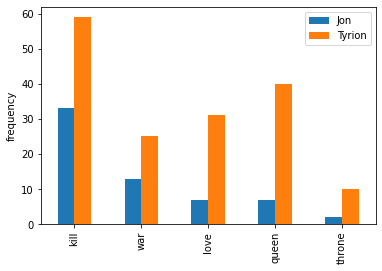

In [55]:
jon.merge(tyrion, on='word').set_index('word').plot(kind='bar', xlabel='', ylabel='frequency')

<br> 

# Part 2: Emotion Mining

The first step of the second part is the collection, evaluation and combination of different annotated datasets, in order to create a new dataset on which the algorithms can be trained. In total 7 datasets were collected, however only 5 of them were incorporated to the final dataset. The reason why two of them were excluded, is that the first one consists of many outliers (the sentences are much longer than in the other datasets and the main corpus), while the second includes tweets. The structure of the language, as well as the vocabulary used in tweets, is very different from the text on which emotion mining will be applied, thus in order to avoid deteriorating the perfomance of the algorithms, this dataset was also excluded.   

A rough description of the workflow that was followed:

- Training Dataset creation

- Text preprocessing

- TF-IDF with Bayes and SVMs

- Word Embeddings with bi-directional LSTMs

- Visualization of the emotion change as a streamgraph 

## Game of Thrones dataset 

This is the main corpus. It is not annotated and after training the model on the other datasets, emotion mining will be performed on this corpus.

In [56]:
raw_corpus = pd.read_csv(data_folder + 'got_corpus.csv', delimiter=';')
raw_corpus = raw_corpus.drop(['Column1', 'Emision Date', 'Episode', 'N_Season','N_serie'], axis = 1)                               
raw_corpus.head()

,Season,Sentence,Name
0,Season 1,"What d’you expect? They’re savages One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces",waymar royce
1,Season 1,"I’ve never seen wildlings do a thing like this I’ve never seen a thing like this, not ever in my life",will
2,Season 1,How close did you get?,waymar royce
3,Season 1,Close as any man would,will
4,Season 1,We should head back to the wall,gared


## Datasets for emotion mining training

#### Read DailyDialog dataset

In [57]:
dailydialog = pd.read_csv(data_folder + "dataset5_dailydialog.txt", engine='python', error_bad_lines=False, sep=",")
dailydialog['Emotion'].replace({0: "other", 1: "anger", 2: "disgust", 3: "fear", 4: "joy", 5: "sadness", 6: "surprise"}, inplace = True)
dailydialog.rename(columns = {'Text':'Sentence'}, inplace= True)
dailydialog.head()

Skipping line 56399: unexpected end of data


,Emotion,Sentence
0,other,"Say , Jim , how about going for a few beers after dinner ?"
1,other,You know that is tempting but is really not good for our fitness .
2,other,What do you mean ? It will help us to relax .
3,other,Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ?
4,other,I guess you are right.But what shall we do ? I don't feel like sitting at home .


In [58]:
dailydialog['Emotion'].value_counts()

other       45025
joy          8632
surprise     1199
sadness       609
anger         565
disgust       268
fear           99
Name: Emotion, dtype: int64

#### Read ISEAR dataset


In [60]:
isear = pd.read_csv(data_folder + "dataset6_isear.txt", sep=",", names=['Emotion', 'Sentence'])
isear.drop([0], inplace = True)
isear.head()

,Emotion,Sentence
1,joy,During the period of falling in love
2,fear,When I was involved in a traffic accident.
3,anger,When I was driving home after several days of hard work
4,sadness,When I lost the person who meant the most to me.
5,disgust,The time I knocked a deer down - the sight of the animal's injuries and helplessness. The realization that the animal was so badly hurt that it had to be put down


In [61]:
isear['Emotion'].value_counts()

fear       1081
joy        1081
anger      1071
disgust    1067
sadness    1067
shame      1054
guilt      1052
Name: Emotion, dtype: int64

#### Read Stimulus dataset

In [62]:
stimulus = pd.read_csv(data_folder + "dataset7_stimulus.txt", sep=",", names=['Emotion', 'Sentence'])
stimulus.drop([0], inplace = True)
stimulus.head()

,Emotion,Sentence
1,happy,I suppose I am happy being so ` tiny' ; it means I am able to surprise people with what is generally seen as my confident and outgoing personality .
2,happy,Lennox has always truly wanted to fight for the world title and was happy taking the tough route .
3,happy,"He was a professional musician now , still sensitive and happy doing something he loved ."
4,happy,Holmes is happy having the freedom of the house when we are out .
5,happy,"I had problems with tutors trying to encourage me to diversity my work and experiment with other styles , but I was quite happy with the direction my work was heading so I stubbornly stuck to it ."


In [63]:
stimulus['Emotion'].value_counts()

sad         575
anger       483
happy       479
fear        423
surprise    213
shame       146
disgust      95
Name: Emotion, dtype: int64

#### Read Dataset 3

In [64]:
# read train data
df3_train = pd.read_csv(data_folder + "dataset3_train.txt", sep=";", names=['Sentence', 'Emotion'])
df3_train.head()

,Sentence,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [65]:
# read test data
df3_test = pd.read_csv(data_folder + "dataset3_test.txt", sep=";", names=['Sentence', 'Emotion'])
df3_test.head()

,Sentence,Emotion
0,im feeling rather rotten so im not very ambitious right now,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy
4,i was feeling a little vain when i did this one,sadness


In [66]:
# read validation data
df3_val = pd.read_csv(data_folder + "dataset3_val.txt", sep=";", names=['Sentence', 'Emotion'])
df3_val.head()

,Sentence,Emotion
0,im feeling quite sad and sorry for myself but ill snap out of it soon,sadness
1,i feel like i am still looking at a blank canvas blank pieces of paper,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [67]:
# Combine the three of them to one
df3 = pd.concat([df3_train, df3_test, df3_val],ignore_index=True)
df3['Emotion'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Emotion, dtype: int64

# Friends dataset

In [68]:
# read train data
df8_train = pd.read_csv(data_folder + "dataset8_train_sent_emo.csv", encoding = 'utf-8')[['Utterance','Emotion']]
df8_train.rename(columns = {'Utterance':'Sentence'}, inplace= True)
df8_train.head(5)

,Sentence,Emotion
0,also I was the point person on my companys transition from the KL-5 to GR-6 system.,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise


In [69]:
df8_train['Emotion'].value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64

In [70]:
# read test data
df8_test= pd.read_csv(data_folder + "dataset8_test_sent_emo.csv", encoding = 'utf-8')[['Utterance','Emotion']]
df8_test.rename(columns = {'Utterance':'Sentence'}, inplace= True)
df8_test.head()

,Sentence,Emotion
0,Why do all youre coffee mugs have numbers on the bottom?,surprise
1,"Oh. Thats so Monica can keep track. That way if one on them is missing, she can be like, Wheres number 27?!",anger
2,Y'know what?,neutral
3,"Come on, Lydia, you can do it.",neutral
4,Push!,joy


In [71]:
df8_test['Emotion'].value_counts()

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: Emotion, dtype: int64

In [72]:
# read validation data
df8_dev= pd.read_csv(data_folder + "dataset8_dev_sent_emo.csv", encoding = 'utf-8')[['Utterance','Emotion']]
df8_dev.rename(columns = {'Utterance':'Sentence'}, inplace= True)
df8_dev.head()

,Sentence,Emotion
0,"Oh my God, hes lost it. Hes totally lost it.",sadness
1,What?,surprise
2,"Or! Or, we could go to the bank, close our accounts and cut them off at the source.",neutral
3,Youre a genius!,joy
4,"Aww, man, now we wont be bank buddies!",sadness


In [73]:
df8_dev['Emotion'].value_counts()

neutral     470
joy         163
anger       153
surprise    150
sadness     111
fear         40
disgust      22
Name: Emotion, dtype: int64

In [74]:
# Combine the three of them to one
friends = pd.concat([df8_train, df8_test, df8_dev], ignore_index=True)
friends['Emotion'].value_counts()

neutral     6436
joy         2308
surprise    1636
anger       1607
sadness     1002
disgust      361
fear         358
Name: Emotion, dtype: int64

In [75]:
# an encoding error was spotted and fixed
def encoding_error(sentence):
    sentence = sentence.replace('', ' ')
    
    return sentence

friends['Sentence'] = friends.Sentence.apply(encoding_error)
friends.head()

,Sentence,Emotion
0,also I was the point person on my company s transition from the KL-5 to GR-6 system.,neutral
1,You must ve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let s talk a little bit about your duties.,neutral
4,My duties? All right.,surprise


### Combine datasets

All the datasets will now be merged into a combined dataset.

In [76]:
raw_train_data = pd.concat([dailydialog, isear, stimulus, df3, friends],ignore_index=True)
raw_train_data.head()

,Emotion,Sentence
0,other,"Say , Jim , how about going for a few beers after dinner ?"
1,other,You know that is tempting but is really not good for our fitness .
2,other,What do you mean ? It will help us to relax .
3,other,Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ?
4,other,I guess you are right.But what shall we do ? I don't feel like sitting at home .


In [77]:
raw_train_data['Emotion'].value_counts()

other       45025
joy         18782
sadness      8475
neutral      6436
anger        6435
fear         4334
surprise     3767
disgust      1791
love         1641
shame        1200
guilt        1052
sad           575
happy         479
Name: Emotion, dtype: int64

### Not used datasets

#### Dataset 1 - very noisy

In [242]:
# ## Not the best choice limits to 4 sentiments without many sentences

# df1 = pd.read_csv(data_folder + "dataset1_train.csv")
# df1['Emotion'].replace({0:'joy',1:'fear',2:'anger',3:'sadness'}, inplace = True)
# df1 = df1[df1['Emotion'] != 4]
# df1 = df1[df1['Emotion'] != 5]
# df1 = df1[df1['Emotion'] != 6]
# df1.rename(columns = {'Comment':'Sentence'}, inplace = True)
# df1.head(30)

In [244]:
# for sentence in df1['Sentence']:
#     sentence = ' '.join([line.strip() for line in sentence.strip().splitlines() if line.strip()])

In [245]:
# df1['Emotion'].value_counts()

#### Dataset 2 - Tweets

In [285]:
# # Tweets. Could avoid, yet offer many sentences

# tweets = pd.read_csv(data_folder + "dataset2_tweet_emotions.csv")
# tweets = tweets.drop(["tweet_id"], axis = 1)
# tweets.rename(columns = {'content':'Sentence', 'sentiment':'Emotion'}, inplace= True )
# #tweets['Emotion'].replace({'worry':'fear', 'happiness':'joy', 'fun':'joy', 'hate':'anger'}, inplace = True)
# tweets.head(10)

In [287]:
# # Cleaning the data and focusing only on the aforementioned emotions

# tweets = tweets[tweets['Emotion'] != "neutral"]
# tweets = tweets[tweets['Emotion'] != "boredom"]
# tweets = tweets[tweets['Emotion'] != "empty"]
# tweets = tweets[tweets['Emotion'] != "relief"]
# tweets = tweets[tweets['Emotion'] != "love"]
# tweets = tweets[tweets['Emotion'] != "enthusiasm"]
# tweets = tweets[tweets['Emotion'] != "worry"]
# tweets = tweets[tweets['Emotion'] != "hate"]
# tweets = tweets[tweets['Emotion'] != "fun"]

# tweets['Emotion'].replace({'happiness':'joy'}, inplace = True)

In [288]:
# tweets['Emotion'].value_counts()

# Analyse the final dataset

The emotions that will be targeted are: happiness, sadness, disgust, fear, surprise, and anger. For this reason, other emotions were removed. In addition, in some datasets the same emotion is expressed with different words, thus these cases were renamed under the same word.

In [78]:
# rename some emotions for consistency
raw_train_data['Emotion'].replace({'worry':'fear', 'sad':'sadness', 'happy':'joy'}, inplace = True)

In [79]:
# remove the following emotions entirely: guilt, love, shame, neutral
raw_train_data = raw_train_data[~raw_train_data.Emotion.isin(['guilt','love','shame','neutral'])]

In [80]:
raw_train_data['Emotion'].value_counts()

other       45025
joy         19261
sadness      9050
anger        6435
fear         4334
surprise     3767
disgust      1791
Name: Emotion, dtype: int64

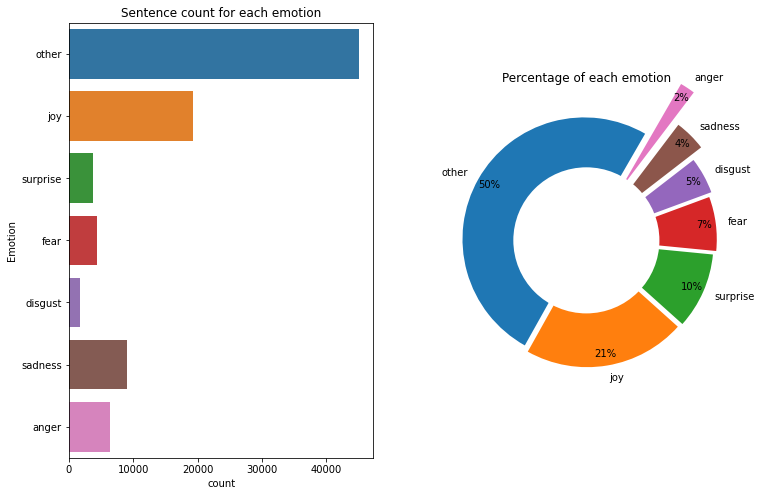

In [81]:
col = 'Emotion'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(raw_train_data[col].dropna().value_counts()))/sum(list(raw_train_data[col].dropna().value_counts())))[::-1])[:10]
labels = list(raw_train_data[col].dropna().unique())[:10]
sizes = raw_train_data[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes, explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns_plot = sns.countplot(y =col, data = raw_train_data, ax=ax1)
ax1.set_title("Sentence count for each emotion")
ax2.set_title("Percentage of each emotion")
#sns_plot.savefig("output.png")
plt.show()

In [283]:
# saving the combined dataset into a .csv file for later use
raw_train_data.to_csv(data_folder + 'raw_train_data.csv', index = False)

# Kappa distance calculation

Despite the annotation of the data, which is described in the report, is considered as accurate and trustworthy, manual inspection was performed by me and another masters student. For the evaluation of this procedure, the Kappa distance was calculated. The classes were encoded as follows: joy=0, anger=1, fear=2, surprise=3 ,disgust=4, sadness=5.

The Kappa score between the current annotations exceeds 80% in both cases. Thus the data is considered as acceptably well annotated.

#### Manual annotation of 100 samples

In [233]:
sample = raw_train_data.sample(n=200, random_state=1)

# Exclude sentences belonging to the class 'other'
sample = sample[sample['Emotion'] != 'other']
print(sample.shape)
sample

(101, 2)


,Emotion,Sentence
99927,joy,i feel calm just thinking about it
28152,joy,"I believe it . Hoo , this car corners like it's on rails ."
40935,joy,"If it were up to Stanley , we'd have the wedding in the ETV ! He loves to sing ."
82462,joy,i hope he makes some friends and feels welcomed
70247,anger,"I-I wanna be with her, I like her."
27470,joy,I like the sight and the sound . It worked on me like a magic when I was a child
93799,fear,i am feeling pretty shaky and sad
87925,joy,i feel like im getting barely as much free time here as i do at oxford
68835,joy,You're so sweet!
16264,joy,"We have a runner on third and up at bat is Brian Okapi ! There ’ s the pitch , he hits it ! It ’ s going , going , that ball is gone !"


In [86]:
# The current labels
y_annot = [0,0,0,0,1,0,2,0,0,0,0,3,4,1,2,0,5,3,1,5,1,1,2,2,3,5,1,0,3,0,5,0,0,0,0,5,0,5,1,5,0,0,0,5,0,0,5,0,5,5,1,0,0,4,5,0,0,0,3,0,1,0,5,2,0,0,4,0,0,0,0,5,5,0,5,2,4,1,0,0,3,0,0,3,1,4,5,3,3,2,0,0,5,1,5,0,1,5,0,0,1]
# To verify that I had not missed any instances
print(len(y_annot))

# Labels provided by me. I also used a seventh class '6' for the cases that I would not assign to any of the previous classes
y_1 = [6,6,0,2,0,0,5,5,0,0,0,3,4,6,2,0,5,3,1,5,1,1,2,2,3,5,1,0,3,0,5,0,0,6,0,5,0,5,1,5,0,0,0,5,0,0,5,0,5,5,1,0,0,4,5,0,0,0,3,0,1,0,5,2,0,0,4,0,0,0,0,5,5,0,5,2,4,1,0,0,3,0,0,3,1,4,5,3,3,2,0,6,5,1,5,0,1,5,0,0,1]

# Labels provided by another annotator. The seventh class '6' was used here as well.
y_2 = [0,6,0,0,0,0,5,1,0,6,0,3,4,6,2,0,5,3,1,5,1,1,2,2,3,5,1,0,3,0,5,0,0,6,0,5,0,5,1,5,0,6,0,5,0,0,5,0,5,5,1,0,0,4,5,0,6,0,3,0,1,0,5,2,0,0,4,0,0,0,6,5,5,0,5,2,4,1,0,0,3,0,0,3,1,4,5,3,3,2,0,6,5,1,5,0,1,5,0,6,1]

print(cohen_kappa_score(y_annot, y_1))
print(cohen_kappa_score(y_annot, y_2))
print(cohen_kappa_score(y_1, y_2))

101
0.8796345338983051
0.8426587044008828
0.8968335035750766


# Text preprocessing

The removal of specific words, like negation words, can completely change the meaning of a sentence. For this reason, negation words were excluded from the stopwords list, by creating a new custom stopwords list. In order to compare the effect of negation handling two different preprocessing functions were developed.

In [169]:
# customising stop words list to remove negation tokens

stopwords = nltk.corpus.stopwords.words("english")
non_stopwords = ['not','no','never','none','nor','hadn','mustn',"didn't",'doesn',"hadn't","mustn't",
                 'mightn','haven',"aren't","haven't",'weren','didn',"couldn't","doesn't","hasn't",'isn',
                 'wasn','needn','mustn',"weren't",'don','couldn','wouldn',"mightn't","wouldn't","don't",
                 'ain',"shouldn't",'aren',"isn't","needn't","wasn't",'shouldn','hasn',"won't"]
my_stopwords = set([word for word in stopwords if word not in non_stopwords])

print("Total number of stopwords is:" + " " + str(len(my_stopwords)))

Total number of stopwords is: 142


In [8]:
# In this case, negation handling is not performed

def preprocessing_basic(sentence):
    # convert to lowercase
    sentence = sentence.lower()    
    
    # remove punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]
    sentence = ''.join(nopunc)
    
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split() if word not in my_stopwords]) 
    
    # lemmatization
    doc = nlp(sentence)
    sentence = [token.lemma_ if ('PRON' not in token.lemma_) & (len(token.lemma_) > 2) else '' for token in doc]
        
    # remove empty tokens
    sentence = list(filter(('').__ne__, sentence))

    return ' '.join([word for word in sentence])

In [89]:
basic_train_data = pd.read_csv(data_folder + 'raw_train_data.csv')

In [90]:
# applying the preprocessing on the training data
basic_train_data['Sentence'] = basic_train_data.Sentence.apply(preprocessing_basic)

In [101]:
# the preprocessed training dataset is saved in a .csv file for future use
basic_train_data.to_csv(data_folder + 'preprocessed_basic_train_data.csv', index = False)

## Negation handling

It was decided to use words(tokens) as features to train the machine learning models. Bearing this in mind, the aim was to find a way to capture the context of a negation, into a single term. This way, the models can be trained more accurately.

For this to be achieved, firstly, POS tagging was performed to identify the adjectives and verbs. Afterwards, the bigrams of each sentence are checked and whenever a negating word is identified, if the following word is an adjective or a verb, it is substituted by its antonym and the negation word is removed. The reason why the focus is only on adjectives and verbs is that the negation of these terms can affect the context of a sentence. 

An example of this approach is the following; given the sentence "The weather today is not bad", the script locates the word "not", then checks the next word's POS tag, which is adjective, and substitutes it by its antonym. This results in the following sentence; "The weather today is good".

The remaining preprocessing steps, conversion to lowercase, punctuation removal and lemmatization are identical to the word frequency task.

In [165]:
def negation_handling(unigram):
    antonyms = []
    
    # if word after "not" is adjective or verb
    if nlp(unigram)[0].pos_ in ['ADJ','VERB']:
        
        # find antonyms
        for syn in wordnet.synsets(unigram): 
            for l in syn.lemmas():
                if l.antonyms():
                    antonyms.append(l.antonyms()[0].name())
                    
    # keep unique antonyms
    antonyms = set(antonyms)
    
    # return first adjective antonym
    for antonym in antonyms:
        # Since we want to avoid substituting for example a verb with an
        # adjective, the POS tagging must be the same
        if nlp(antonym)[0].pos_ == nlp(unigram)[0].pos_:
            return antonym
        
    # if no adj antonym found, return original word
    return unigram

In [166]:
# In this case, negation handling is performed by checking the bi-grams and substituting negative bi-grams with their antonyms

def preprocessing(sentence):
    # convert to lowercase
    sentence = sentence.lower()    
    
    # remove punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]
    sentence = ''.join(nopunc)
    
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split() if word not in my_stopwords]) 
    
    # lemmatization
    doc = nlp(sentence)
    sentence = [token.lemma_ if ('PRON' not in token.lemma_) & (len(token.lemma_) > 2) else '' for token in doc]
        
    # remove empty tokens
    sentence = list(filter(('').__ne__, sentence))

    # negation handling
    antonyms = {}
    for idx, (first, second) in enumerate(zip(sentence, sentence[1:])):
        if first in non_stopwords:
            antonyms[idx-len(antonyms.keys())] = negation_handling(second)
            
    for key in antonyms.keys():
        sentence[key] = antonyms[key]
        sentence.pop(key+1)
        
    return ' '.join([word for word in sentence])

In [ ]:
# An example of how this function operates. Of course, the result is imposed to lemmatization and the other preprocessing steps
# but still, it can be seen that 'not' is removed and 'good' is substituted by 'bad'.
sentence1 = "The weather today is not good"

In [170]:
preprocessing(sentence1)

'wather today bad'

### Pre-processing the training data by performing negation handling

In [18]:
# old raw_combined_set
raw_train_data = pd.read_csv(data_folder + 'raw_train_data.csv')

In [19]:
train_data = raw_train_data.copy(deep=True)
train_data['Sentence'] = train_data.Sentence.apply(preprocessing)

In [20]:
# Removing empty sentences that occur after the removal of the stopwords
train_data = train_data[train_data['Sentence'].map(lambda d: len(d)) > 0]
train_data.head()

,Emotion,Sentence
0,other,say jim beer dinner
1,other,know tempting really ill fitness
2,other,mean help relax
3,other,really think make fat act silly remember last time
4,other,guess rightbut shall feel like sit home


In [21]:
train_data['Emotion'].value_counts()

other       43994
joy         19063
sadness      9005
anger        6359
fear         4311
surprise     3495
disgust      1769
Name: Emotion, dtype: int64

In [102]:
# Saving for future use
train_data.to_csv(data_folder + 'preprocessed_train_data.csv', index = False)

# Data Augmentation

Due to class imbalance, I import synthetic samples by replacing the nouns, verbs and adjectives of the sentences from the under-represented classes. Again, two different cases will be compared. The intuition behind this is that if too many syntetic data is created, bias might be introduced and lower the quality of the training of the models. Bearing this in mind, in the first case, less synthetic data were created, without totally balancing the classes. In the second case, more synthetic data are produced and the classes are almost equally balanced.

In [54]:
train_data = pd.read_csv(data_folder + 'preprocessed_train_data.csv')
train_data.head()

,Emotion,Sentence
0,other,say jim beer dinner
1,other,know tempting really bad fitness
2,other,mean help relax
3,other,really think make fat act silly remember last time
4,other,guess rightbut shall feel like sit home


In [39]:
# Getting the synonyms of the selected words

def get_synonyms(word):
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            if synonym != '':
                synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [40]:
# Creating new sentences by replacing the synonyms of nouns, verbs and adjectives

def synonym_replacement(sentence):
    sentence = sentence.split()
    returned_sentence = []
    
    for token in sentence:
        
        # If the word is a noun, verb or adjective
        if nlp(token)[0].pos_ in ['NOUN','VERB','ADJ']:
   
            synonyms = get_synonyms(token)
    
            synonym_found = 0
            for synonym in synonyms:
                # Since many different synonyms are returned, only those that have the same POS tag are substituted,
                #so that a noun for instance, is not substituted by a verb
                if (nlp(synonym)[0].pos_ == nlp(token)[0].pos_) & (len(synonym) >= 3):
                    returned_sentence.append(synonym)
                    synonym_found = 1
                    break
        
            if synonym_found == 0:
                returned_sentence.append(token)
        else:
            returned_sentence.append(token)
    
    return ' '.join([word for word in returned_sentence])

In [106]:
augmented_train_data = train_data.copy(deep=True)

# Augmenting the data by the respective number: 'disqust' is tripled, while 'surprise', 'fear' and 'anger are doubled'.
emotion_oversampling = ['disgust','disgust','surprise','fear','anger']

for emotion in emotion_oversampling:
    new_samples = train_data[train_data.Emotion == emotion].Sentence.apply(synonym_replacement).to_frame()
    new_samples['Emotion'] = emotion
    
# Concatenating the artificially created sentences to the existing dataset    
    augmented_train_data = pd.concat([augmented_train_data, new_samples])

In [107]:
# In this case the classes are not evenly balanced, but the imbalance is alleviated
augmented_train_data['Emotion'].value_counts()

other       43994
joy         19063
anger       12718
sadness      9005
fear         8622
surprise     6990
disgust      5307
Name: Emotion, dtype: int64

In [108]:
# saving augmented training data for later use
augmented_train_data.to_csv(data_folder + 'augmented_train_data.csv', index = False)

In [57]:
# In this second example, the classes are more balanced

augmented_train_data2 = train_data.copy(deep=True)

emotion_oversampling = ['disgust','disgust','disgust','disgust','surprise','surprise','fear','anger']
for emotion in emotion_oversampling:
    new_samples = train_data[train_data.Emotion == emotion].Sentence.apply(synonym_replacement).to_frame()
    new_samples['Emotion'] = emotion
    
    augmented_train_data2 = pd.concat([augmented_train_data2, new_samples])

In [59]:
augmented_train_data2['Emotion'].value_counts()

other       43994
joy         19063
anger       12718
surprise    10485
sadness      9005
disgust      8845
fear         8622
Name: Emotion, dtype: int64

In [60]:
# saving augmented training data for later use
augmented_train_data2.to_csv(data_folder + 'augmented_train_data2.csv', index = False)

# Training Machine Learning models 

## TF-IDF and Multinomial Naive Bayes

In [33]:
def tfidf_nb(filename, labels, max_features = False, remove_other = False, undersampling = 0):
    
    # read dataset and replace emotion strings with numbers
    data = pd.read_csv(data_folder + filename).fillna('')
    data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
    
    # drop empty rows
    data = data[data['Sentence'].map(lambda d: len(d)) > 0]
    
    # undersample class 'other'
    if remove_other:
        data = data[data.Emotion != 0]
    elif undersampling > 0:
        data = data.drop(data[data.Emotion == 0].sample(undersampling).index)
    
    # split train-test data
    X_train, X_test, y_train, y_test = train_test_split(data.Sentence, data.Emotion, train_size = 0.8)
    
    # apply tf-idf (if necessary limit the number of features for computational reasons)
    if max_features:
        tfidf_vectorizer = TfidfVectorizer(max_features = 10000)
    else:
        tfidf_vectorizer = TfidfVectorizer()
    X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
    X_test = tfidf_vectorizer.transform(X_test).toarray()
    
    # train Naive Bayes
    m_naive_bayes = MultinomialNB()
    m_naive_bayes.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = m_naive_bayes.predict(X_test)
    
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, labels=labels))
    print('\nConfusion Matrix:')
    #print(confusion_matrix(y_test, y_pred, labels=labels))
    plot_confusion_matrix(y_test, y_pred, classes = [class_names[x] for x in labels], normalize=True)

#### Basic experiment - no negation handling, no augmentation

Firstly, we will evaluate how well Naive Bayes performs on the training set, without handling negations and augmenting the data. As can be seen, it is very biased towards the majority class 'other'.

Accuracy: 0.6702840909090909

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.96      0.77      8749
           1       0.83      0.26      0.39      1275
           2       0.83      0.01      0.03       353
           3       0.88      0.21      0.34       857
           4       0.68      0.48      0.56      3863
           5       0.80      0.53      0.64      1814
           6       0.78      0.06      0.12       689

    accuracy                           0.67     17600
   macro avg       0.78      0.36      0.41     17600
weighted avg       0.70      0.67      0.62     17600


Confusion Matrix:


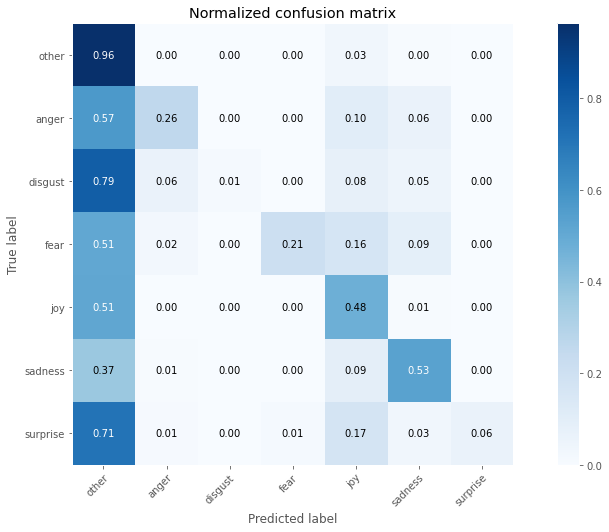

In [221]:
# simple basic preprocessing
tfidf_nb('preprocessed_basic_train_data.csv', labels=[0,1,2,3,4,5,6], max_features=True)

### With negation handling

Accuracy: 0.6692613636363637

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.96      0.78      8835
           1       0.83      0.28      0.42      1275
           2       0.88      0.02      0.04       355
           3       0.91      0.22      0.35       868
           4       0.66      0.47      0.55      3752
           5       0.79      0.53      0.63      1808
           6       0.80      0.06      0.10       707

    accuracy                           0.67     17600
   macro avg       0.79      0.36      0.41     17600
weighted avg       0.70      0.67      0.62     17600


Confusion Matrix:


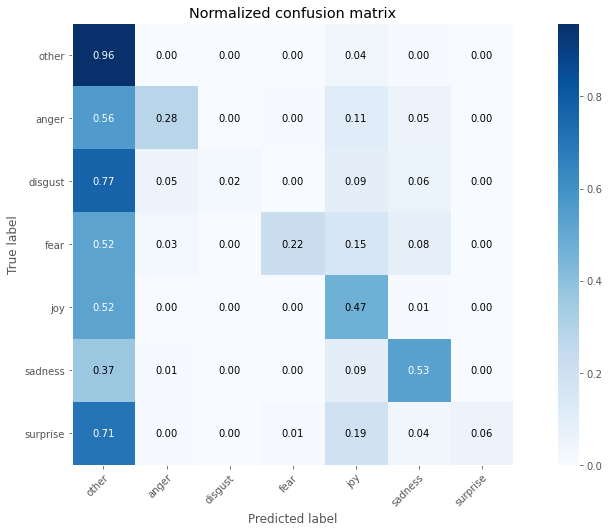

In [222]:
# negation handling
tfidf_nb('preprocessed_train_data.csv', labels=[0,1,2,3,4,5,6], max_features=True)

### With negation handling and augmentation

Accuracy: 0.6683538315988647

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.96      0.77      8768
           1       0.63      0.58      0.60      2592
           2       0.79      0.31      0.44      1051
           3       0.81      0.48      0.60      1769
           4       0.68      0.48      0.56      3656
           5       0.80      0.52      0.63      1858
           6       0.78      0.24      0.37      1446

    accuracy                           0.67     21140
   macro avg       0.73      0.51      0.57     21140
weighted avg       0.69      0.67      0.64     21140


Confusion Matrix:


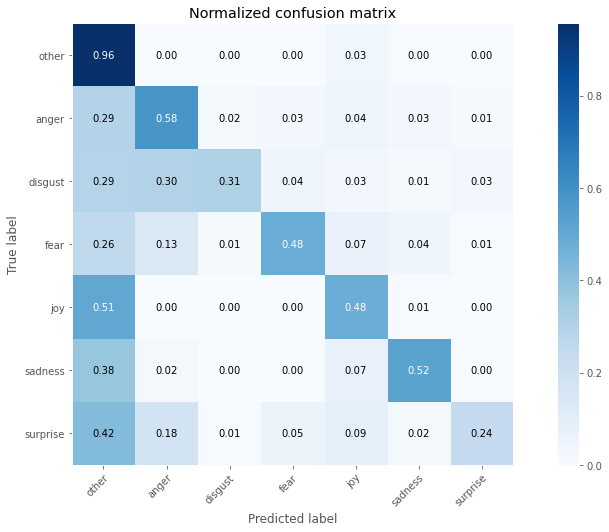

In [223]:
# data augmentation
tfidf_nb('augmented_train_data.csv', labels=[0,1,2,3,4,5,6], max_features=True)

### Undersampling class 'other'

As expected, accuracy drops, because the model was almost perfectly predicting all instances of this class. However, the predictions on the other classes are improved.

Accuracy: 0.627233782129743

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.80      0.66      3927
           1       0.61      0.63      0.62      2546
           2       0.79      0.29      0.43      1068
           3       0.78      0.53      0.63      1738
           4       0.60      0.72      0.65      3878
           5       0.78      0.61      0.68      1801
           6       0.73      0.27      0.40      1382

    accuracy                           0.63     16340
   macro avg       0.69      0.55      0.58     16340
weighted avg       0.66      0.63      0.62     16340


Confusion Matrix:


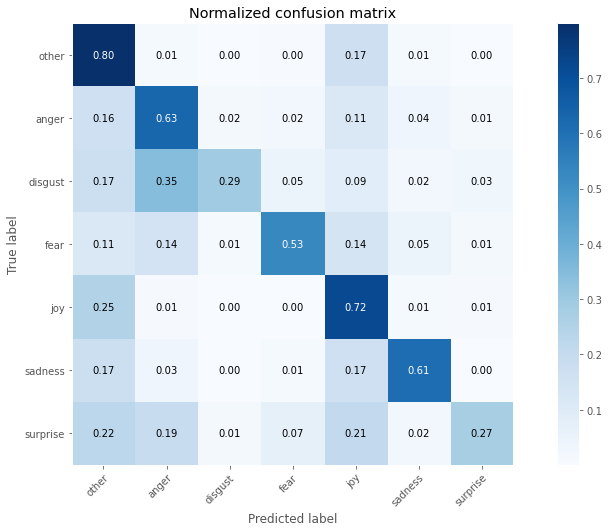

In [224]:
# class 'other' undersampled
tfidf_nb('augmented_train_data.csv', labels=[0,1,2,3,4,5,6], max_features=True, undersampling=24000)

### Totally removing the class 'other'

Accuracy: 0.6696377927234421

Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.67      0.64      2472
           2       0.78      0.28      0.41      1020
           3       0.82      0.55      0.66      1711
           4       0.63      0.97      0.76      3895
           5       0.76      0.66      0.70      1800
           6       0.77      0.30      0.43      1443

    accuracy                           0.67     12341
   macro avg       0.73      0.57      0.60     12341
weighted avg       0.70      0.67      0.65     12341


Confusion Matrix:


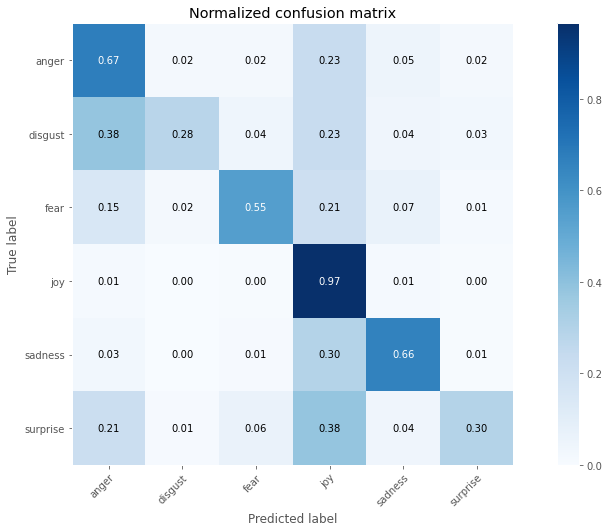

In [227]:
# no class 'other'
tfidf_nb('augmented_train_data.csv', labels=[1,2,3,4,5,6], max_features=True, remove_other=True)

### More balanced classes and undersampling class 'other'

Again, even if accuracy drops, the predictions on the other classes are much better. 

Accuracy: 0.6531808192934017

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.79      0.67      3993
           1       0.67      0.53      0.59      2555
           2       0.74      0.68      0.71      1768
           3       0.83      0.46      0.59      1682
           4       0.60      0.73      0.66      3847
           5       0.78      0.60      0.68      1781
           6       0.73      0.58      0.65      2121

    accuracy                           0.65     17747
   macro avg       0.71      0.62      0.65     17747
weighted avg       0.68      0.65      0.65     17747


Confusion Matrix:


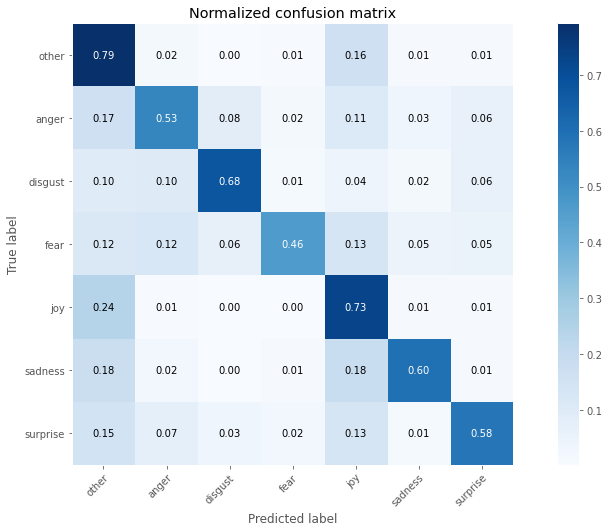

In [225]:
# class 'other' undersampled
tfidf_nb('augmented_train_data2.csv', labels=[0,1,2,3,4,5,6], max_features=True, undersampling=24000)

### More balanced classes and removal of class 'other'

This approach gave the best results.

Accuracy: 0.7019930171661333

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.58      0.63      2515
           2       0.76      0.69      0.72      1790
           3       0.86      0.51      0.64      1729
           4       0.63      0.95      0.76      3831
           5       0.78      0.65      0.71      1815
           6       0.73      0.60      0.66      2068

    accuracy                           0.70     13748
   macro avg       0.74      0.66      0.69     13748
weighted avg       0.72      0.70      0.69     13748


Confusion Matrix:


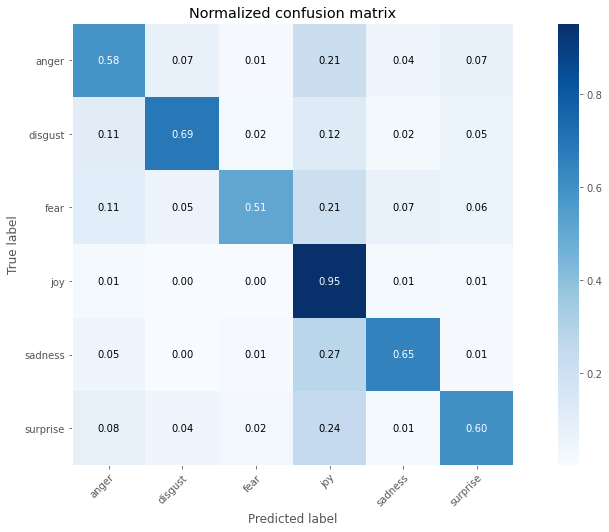

In [226]:
tfidf_nb('augmented_train_data2.csv', labels=[1,2,3,4,5,6], max_features=True, remove_other=True)

### Sample of Gaussian NB on 'Basic' dataset (simple preprocessing)

### (Tested but not used)

Gaussian Naive Bayes performed very badly, thus it was not further explored.

In [119]:
# data = pd.read_csv(data_folder + 'preprocessed_basic_train_data.csv').fillna('')
# data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
# #drop empty rows
# data = data[data['Sentence'].map(lambda d: len(d)) > 0]

In [120]:
# # split train-test data
# X_train, X_test, y_train, y_test = train_test_split(data.Sentence, data.Emotion, train_size = 0.8)

In [123]:
# # tf-idf
# tfidf_vectorizer = TfidfVectorizer()
# X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
# X_test = tfidf_vectorizer.transform(X_test).toarray()

In [116]:
# #Create a Gaussian Classifier
# naive_bayes = GaussianNB()

In [124]:
# #Train the model using the training sets
# naive_bayes.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = naive_bayes.predict(X_test)

In [125]:
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.16943181818181818


# TF-IDF and SVMs

In [228]:
def tfidf_svms(filename, labels, max_features = False, remove_other = False, undersampling = 0):
    # read dataset and replace emotion strings with numbers
    data = pd.read_csv(data_folder + filename).fillna('')
    data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
    
    # drop empty rows
    data = data[data['Sentence'].map(lambda d: len(d)) > 0]
    
    # undersample class 'other'
    if remove_other:
        data = data[data.Emotion != 0]
    elif undersampling > 0:
        data = data.drop(data[data.Emotion == 0].sample(undersampling).index)
    
    # split train-test data
    X_train, X_test, y_train, y_test = train_test_split(data.Sentence, data.Emotion, train_size = 0.9, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
    
    # apply tf-idf (if necessary limit the number of features for computational reasons)
    if max_features:
        tfidf_vectorizer = TfidfVectorizer(max_features = 10000)
    else:
        tfidf_vectorizer = TfidfVectorizer()
    X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
    X_test = tfidf_vectorizer.transform(X_test).toarray()
    X_val = tfidf_vectorizer.transform(X_val).toarray()

    
    
    C = [0.01, 0.05, 0.25, 0.5, 1, 5]
    loss = ['hinge', 'squared_hinge']
    res = ['', 0, 0, 0]
    xaxis = []
    xticks = []
    yaxis = []
    for c in C:
        for l in loss:
            try:
                svm_model = LinearSVC(random_state=0, penalty = 'l2', loss=l, C=c)
                svm_model.fit(X_train, y_train)
                y_pred = svm_model.predict(X_val)
                # for tt in range(len(Y_test)):
                # print "Actual:",Y_test[tt],"  Predicted:",predictedY[tt]
                accuracy = svm_model.score(X_val, y_val)
                print("c, loss:", c, l, "  accuracy:", accuracy)
                #print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
                print('\nClassification Report:')
                print(classification_report(y_val, y_pred, labels=labels))
                #print('\nConfusion Matrix:')
                #print(confusion_matrix(y_val, y_pred, labels=labels))
                #plot_confusion_matrix(y_val, y_pred, classes = class_names2, normalize=True, title='Normalized confusion matrix')
                    
                    
                par = []
                par.append(c)
                par.append(l)
                xaxis.append(len(xticks))
                xticks.append(str(par))
                yaxis.append(accuracy)

                if (res[2] <= accuracy):
                    res[0] = c
                    res[1] = l
                    res[2] = accuracy

            except ValueError:
                    print("value error comes")

    # creating and saving the plot
    plt.xticks(xaxis, xticks, rotation=90)
    plt.plot(xaxis, yaxis)
    plt.tight_layout()
    plt.show()
    # plt.savefig("plot2b_svm.png")

### No negation handling, no augmentation

c, loss: 0.01 hinge   accuracy: 0.5920569329660239
Accuracy: 0.5920569329660239

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.98      0.71      4338
           1       0.95      0.12      0.21       639
           2       0.50      0.01      0.02       176
           3       0.85      0.23      0.36       429
           4       0.78      0.22      0.34      1946
           5       0.88      0.31      0.46       870
           6       0.74      0.06      0.12       314

    accuracy                           0.59      8712
   macro avg       0.75      0.28      0.32      8712
weighted avg       0.69      0.59      0.51      8712

c, loss: 0.01 squared_hinge   accuracy: 0.6604683195592287
Accuracy: 0.6604683195592287

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.96      0.77      4338
           1       0.90      0.15      0.26       639
           2       0.00 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\TextMining\lib\site-packages\

c, loss: 0.05 hinge   accuracy: 0.685376492194674
Accuracy: 0.685376492194674

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77      4338
           1       0.91      0.25      0.40       639
           2       0.56      0.03      0.05       176
           3       0.84      0.42      0.56       429
           4       0.79      0.45      0.57      1946
           5       0.86      0.58      0.69       870
           6       0.68      0.16      0.25       314

    accuracy                           0.69      8712
   macro avg       0.75      0.41      0.47      8712
weighted avg       0.73      0.69      0.65      8712

c, loss: 0.05 squared_hinge   accuracy: 0.7216483011937558
Accuracy: 0.7216483011937558

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      4338
           1       0.83      0.34      0.48       639
           2       0.68   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.7320936639118457
Accuracy: 0.7320936639118457

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.81      4338
           1       0.84      0.38      0.52       639
           2       0.53      0.11      0.18       176
           3       0.81      0.57      0.67       429
           4       0.78      0.57      0.66      1946
           5       0.83      0.68      0.75       870
           6       0.57      0.23      0.32       314

    accuracy                           0.73      8712
   macro avg       0.72      0.50      0.56      8712
weighted avg       0.74      0.73      0.71      8712

c, loss: 0.25 squared_hinge   accuracy: 0.7428833792470156
Accuracy: 0.7428833792470156

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4338
           1       0.76      0.43      0.55       639
           2       0.58 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.7393250688705234
Accuracy: 0.7393250688705234

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.81      4338
           1       0.83      0.40      0.54       639
           2       0.51      0.14      0.22       176
           3       0.79      0.59      0.68       429
           4       0.77      0.59      0.67      1946
           5       0.84      0.70      0.76       870
           6       0.55      0.26      0.36       314

    accuracy                           0.74      8712
   macro avg       0.72      0.52      0.58      8712
weighted avg       0.74      0.74      0.72      8712

c, loss: 0.5 squared_hinge   accuracy: 0.7420798898071626
Accuracy: 0.7420798898071626

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      4338
           1       0.74      0.45      0.56       639
           2       0.49   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.7443755739210285
Accuracy: 0.7443755739210285

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4338
           1       0.81      0.43      0.56       639
           2       0.46      0.17      0.25       176
           3       0.79      0.62      0.69       429
           4       0.76      0.61      0.67      1946
           5       0.84      0.70      0.77       870
           6       0.55      0.30      0.38       314

    accuracy                           0.74      8712
   macro avg       0.70      0.54      0.59      8712
weighted avg       0.74      0.74      0.73      8712

c, loss: 1 squared_hinge   accuracy: 0.7410468319559229
Accuracy: 0.7410468319559229

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      4338
           1       0.72      0.47      0.57       639
           2       0.46      0

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.7380624426078971
Accuracy: 0.7380624426078971

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      4338
           1       0.73      0.45      0.56       639
           2       0.41      0.24      0.30       176
           3       0.74      0.67      0.71       429
           4       0.72      0.62      0.67      1946
           5       0.81      0.70      0.75       870
           6       0.47      0.34      0.40       314

    accuracy                           0.74      8712
   macro avg       0.66      0.56      0.60      8712
weighted avg       0.73      0.74      0.73      8712

c, loss: 5 squared_hinge   accuracy: 0.7287649219467401
Accuracy: 0.7287649219467401

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      4338
           1       0.67      0.46      0.54       639
           2       0.34      0

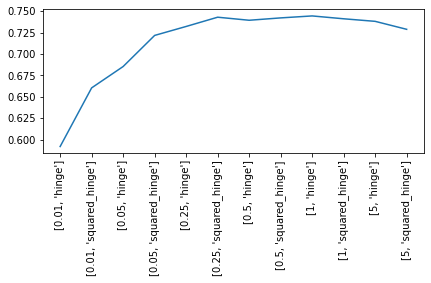

In [26]:
tfidf_svms('preprocessed_basic_train_data.csv', labels=[0,1,2,3,4,5,6], max_features = False)

### With negation handling

c, loss: 0.01 hinge   accuracy: 0.5915977961432507
Accuracy: 0.5915977961432507

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.98      0.71      4338
           1       0.96      0.12      0.22       639
           2       0.50      0.01      0.02       176
           3       0.86      0.22      0.35       429
           4       0.78      0.21      0.34      1946
           5       0.88      0.31      0.46       870
           6       0.66      0.07      0.12       314

    accuracy                           0.59      8712
   macro avg       0.74      0.28      0.32      8712
weighted avg       0.69      0.59      0.51      8712

c, loss: 0.01 squared_hinge   accuracy: 0.6585169880624426
Accuracy: 0.6585169880624426

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.97      0.77      4338
           1       0.91      0.15      0.26       639
           2       0.00 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c, loss: 0.05 hinge   accuracy: 0.6841138659320477
Accuracy: 0.6841138659320477

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77      4338
           1       0.91      0.26      0.40       639
           2       0.50      0.03      0.05       176
           3       0.85      0.41      0.55       429
           4       0.78      0.44      0.57      1946
           5       0.85      0.58      0.69       870
           6       0.65      0.16      0.25       314

    accuracy                           0.68      8712
   macro avg       0.74      0.41      0.47      8712
weighted avg       0.72      0.68      0.65      8712

c, loss: 0.05 squared_hinge   accuracy: 0.7199265381083563
Accuracy: 0.7199265381083563

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      4338
           1       0.82      0.34      0.48       639
           2       0.72 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.7286501377410468
Accuracy: 0.7286501377410468

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.94      0.81      4338
           1       0.82      0.38      0.52       639
           2       0.52      0.10      0.16       176
           3       0.80      0.55      0.65       429
           4       0.78      0.56      0.65      1946
           5       0.82      0.67      0.74       870
           6       0.57      0.23      0.32       314

    accuracy                           0.73      8712
   macro avg       0.71      0.49      0.55      8712
weighted avg       0.74      0.73      0.71      8712

c, loss: 0.25 squared_hinge   accuracy: 0.7404729109274564
Accuracy: 0.7404729109274564

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4338
           1       0.76      0.43      0.55       639
           2       0.57 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.7372589531680441
Accuracy: 0.7372589531680441

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.81      4338
           1       0.81      0.40      0.54       639
           2       0.51      0.14      0.22       176
           3       0.79      0.58      0.67       429
           4       0.77      0.58      0.66      1946
           5       0.83      0.70      0.76       870
           6       0.54      0.26      0.35       314

    accuracy                           0.74      8712
   macro avg       0.71      0.51      0.57      8712
weighted avg       0.74      0.74      0.72      8712

c, loss: 0.5 squared_hinge   accuracy: 0.7397842056932966
Accuracy: 0.7397842056932966

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      4338
           1       0.74      0.45      0.56       639
           2       0.50   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.7418503213957759
Accuracy: 0.7418503213957759

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4338
           1       0.80      0.43      0.56       639
           2       0.48      0.16      0.24       176
           3       0.77      0.60      0.68       429
           4       0.76      0.60      0.67      1946
           5       0.82      0.70      0.76       870
           6       0.55      0.29      0.38       314

    accuracy                           0.74      8712
   macro avg       0.70      0.53      0.59      8712
weighted avg       0.74      0.74      0.73      8712

c, loss: 1 squared_hinge   accuracy: 0.7374885215794307
Accuracy: 0.7374885215794307

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      4338
           1       0.72      0.46      0.56       639
           2       0.47      0

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.7369146005509641
Accuracy: 0.7369146005509641

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      4338
           1       0.72      0.45      0.55       639
           2       0.39      0.23      0.29       176
           3       0.73      0.66      0.69       429
           4       0.72      0.61      0.66      1946
           5       0.80      0.70      0.75       870
           6       0.47      0.33      0.39       314

    accuracy                           0.74      8712
   macro avg       0.66      0.55      0.59      8712
weighted avg       0.73      0.74      0.73      8712

c, loss: 5 squared_hinge   accuracy: 0.7265840220385675
Accuracy: 0.7265840220385675

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      4338
           1       0.67      0.46      0.55       639
           2       0.33      0

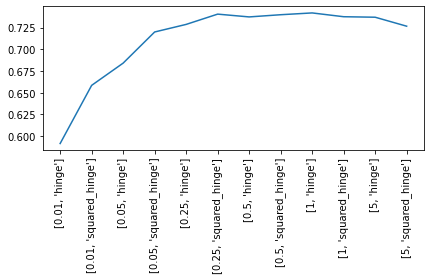

In [27]:
tfidf_svms('preprocessed_train_data.csv', labels=[0,1,2,3,4,5,6], max_features = False)

### With negation handling and slightly agumenting the data

c, loss: 0.01 hinge   accuracy: 0.6014333492594363
Accuracy: 0.6014333492594363

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.97      0.70      4440
           1       0.81      0.32      0.46      1198
           2       0.68      0.17      0.27       530
           3       0.87      0.41      0.56       837
           4       0.74      0.33      0.45      1876
           5       0.86      0.44      0.58       931
           6       0.75      0.20      0.31       653

    accuracy                           0.60     10465
   macro avg       0.75      0.41      0.48     10465
weighted avg       0.68      0.60      0.56     10465

c, loss: 0.01 squared_hinge   accuracy: 0.641280458671763
Accuracy: 0.641280458671763

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.96      0.74      4440
           1       0.68      0.42      0.52      1198
           2       0.67   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.05 hinge   accuracy: 0.6716674629718108
Accuracy: 0.6716674629718108

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.96      0.75      4440
           1       0.76      0.46      0.57      1198
           2       0.67      0.29      0.41       530
           3       0.84      0.57      0.68       837
           4       0.76      0.46      0.57      1876
           5       0.85      0.58      0.69       931
           6       0.70      0.29      0.41       653

    accuracy                           0.67     10465
   macro avg       0.74      0.52      0.58     10465
weighted avg       0.70      0.67      0.65     10465

c, loss: 0.05 squared_hinge   accuracy: 0.7116101290014334
Accuracy: 0.7116101290014334

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.94      0.79      4440
           1       0.73      0.55      0.63      1198
           2       0.70 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.7186813186813187
Accuracy: 0.7186813186813187

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79      4440
           1       0.77      0.55      0.64      1198
           2       0.66      0.46      0.54       530
           3       0.81      0.68      0.74       837
           4       0.75      0.54      0.63      1876
           5       0.82      0.68      0.74       931
           6       0.63      0.39      0.48       653

    accuracy                           0.72     10465
   macro avg       0.73      0.60      0.65     10465
weighted avg       0.73      0.72      0.71     10465

c, loss: 0.25 squared_hinge   accuracy: 0.7355948399426661
Accuracy: 0.7355948399426661

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      4440
           1       0.74      0.61      0.66      1198
           2       0.69 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.7315814620162446
Accuracy: 0.7315814620162446

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81      4440
           1       0.76      0.57      0.65      1198
           2       0.66      0.52      0.58       530
           3       0.80      0.71      0.75       837
           4       0.75      0.57      0.65      1876
           5       0.83      0.70      0.76       931
           6       0.63      0.43      0.51       653

    accuracy                           0.73     10465
   macro avg       0.73      0.63      0.67     10465
weighted avg       0.73      0.73      0.72     10465

c, loss: 0.5 squared_hinge   accuracy: 0.7397993311036789
Accuracy: 0.7397993311036789

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.81      4440
           1       0.74      0.62      0.68      1198
           2       0.69   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.739034878165313
Accuracy: 0.739034878165313

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      4440
           1       0.76      0.59      0.66      1198
           2       0.66      0.58      0.62       530
           3       0.80      0.72      0.76       837
           4       0.73      0.58      0.65      1876
           5       0.83      0.71      0.76       931
           6       0.63      0.46      0.53       653

    accuracy                           0.74     10465
   macro avg       0.73      0.65      0.68     10465
weighted avg       0.74      0.74      0.73     10465

c, loss: 1 squared_hinge   accuracy: 0.7398948877209747
Accuracy: 0.7398948877209747

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      4440
           1       0.74      0.63      0.68      1198
           2       0.68      0.6

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.7397037744863831
Accuracy: 0.7397037744863831

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82      4440
           1       0.73      0.63      0.68      1198
           2       0.66      0.64      0.65       530
           3       0.79      0.73      0.76       837
           4       0.72      0.59      0.65      1876
           5       0.79      0.69      0.74       931
           6       0.62      0.51      0.56       653

    accuracy                           0.74     10465
   macro avg       0.72      0.67      0.69     10465
weighted avg       0.74      0.74      0.73     10465

c, loss: 5 squared_hinge   accuracy: 0.7311992355470617
Accuracy: 0.7311992355470617

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      4440
           1       0.72      0.63      0.68      1198
           2       0.67      0

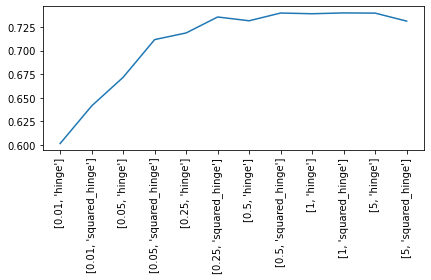

In [28]:
tfidf_svms('augmented_train_data.csv', labels=[0,1,2,3,4,5,6], max_features = False)

### Underspampling the class 'other'

c, loss: 0.01 hinge   accuracy: 0.6590431450117443
Accuracy: 0.6590431450117443

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.82      0.65      1925
           1       0.75      0.58      0.65      1253
           2       0.64      0.46      0.54       510
           3       0.79      0.67      0.73       831
           4       0.68      0.69      0.68      1893
           5       0.80      0.66      0.72       906
           6       0.73      0.44      0.55       771

    accuracy                           0.66      8089
   macro avg       0.71      0.62      0.65      8089
weighted avg       0.68      0.66      0.66      8089

c, loss: 0.01 squared_hinge   accuracy: 0.6045246631227593
Accuracy: 0.6045246631227593

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.87      0.62      1925
           1       0.63      0.52      0.57      1253
           2       0.65 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.05 hinge   accuracy: 0.6655952528124613
Accuracy: 0.6655952528124613

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.82      0.66      1925
           1       0.74      0.58      0.65      1253
           2       0.63      0.48      0.54       510
           3       0.79      0.68      0.73       831
           4       0.70      0.69      0.69      1893
           5       0.79      0.68      0.73       906
           6       0.74      0.45      0.56       771

    accuracy                           0.67      8089
   macro avg       0.71      0.63      0.65      8089
weighted avg       0.69      0.67      0.66      8089

c, loss: 0.05 squared_hinge   accuracy: 0.6785758437384102
Accuracy: 0.6785758437384102

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1925
           1       0.72      0.62      0.66      1253
           2       0.65 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.6880949437507726
Accuracy: 0.6880949437507726

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.83      0.68      1925
           1       0.77      0.61      0.68      1253
           2       0.62      0.54      0.58       510
           3       0.79      0.71      0.75       831
           4       0.74      0.68      0.71      1893
           5       0.80      0.73      0.76       906
           6       0.70      0.51      0.59       771

    accuracy                           0.69      8089
   macro avg       0.71      0.66      0.68      8089
weighted avg       0.71      0.69      0.69      8089

c, loss: 0.25 squared_hinge   accuracy: 0.7002101619483249
Accuracy: 0.7002101619483249

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      1925
           1       0.74      0.65      0.69      1253
           2       0.68 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.6971195450611942
Accuracy: 0.6971195450611942

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1925
           1       0.76      0.62      0.68      1253
           2       0.63      0.59      0.61       510
           3       0.80      0.74      0.77       831
           4       0.75      0.69      0.71      1893
           5       0.79      0.74      0.77       906
           6       0.73      0.51      0.60       771

    accuracy                           0.70      8089
   macro avg       0.72      0.67      0.69      8089
weighted avg       0.71      0.70      0.70      8089

c, loss: 0.5 squared_hinge   accuracy: 0.7031771541599703
Accuracy: 0.7031771541599703

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.80      0.69      1925
           1       0.74      0.66      0.70      1253
           2       0.67   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.6973667944121646
Accuracy: 0.6973667944121646

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.81      0.69      1925
           1       0.75      0.63      0.68      1253
           2       0.61      0.61      0.61       510
           3       0.78      0.74      0.76       831
           4       0.75      0.69      0.72      1893
           5       0.80      0.74      0.77       906
           6       0.71      0.52      0.60       771

    accuracy                           0.70      8089
   macro avg       0.71      0.67      0.69      8089
weighted avg       0.71      0.70      0.70      8089

c, loss: 1 squared_hinge   accuracy: 0.7010755346767215
Accuracy: 0.7010755346767215

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.79      0.68      1925
           1       0.74      0.66      0.70      1253
           2       0.67      0

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.6946470515514896
Accuracy: 0.6946470515514896

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.78      0.69      1925
           1       0.73      0.63      0.68      1253
           2       0.64      0.63      0.63       510
           3       0.77      0.75      0.76       831
           4       0.74      0.69      0.72      1893
           5       0.77      0.73      0.75       906
           6       0.67      0.53      0.59       771

    accuracy                           0.69      8089
   macro avg       0.70      0.68      0.69      8089
weighted avg       0.70      0.69      0.69      8089

c, loss: 5 squared_hinge   accuracy: 0.6832735814068488
Accuracy: 0.6832735814068488

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1925
           1       0.72      0.64      0.68      1253
           2       0.64      0

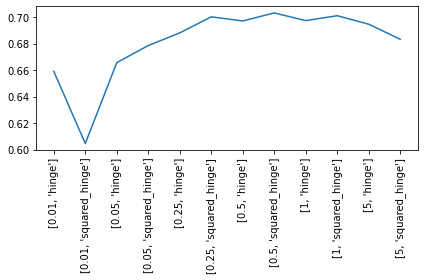

In [29]:
tfidf_svms('augmented_train_data.csv', labels=[0,1,2,3,4,5,6], max_features = True, undersampling = 24000)

### Completely removing the class 'other'

c, loss: 0.01 hinge   accuracy: 0.6744147978392535
Accuracy: 0.6744147978392535

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.56      0.64      1221
           2       0.68      0.46      0.55       552
           3       0.78      0.61      0.68       895
           4       0.61      0.95      0.74      1897
           5       0.78      0.62      0.69       855
           6       0.62      0.45      0.52       689

    accuracy                           0.67      6109
   macro avg       0.71      0.61      0.64      6109
weighted avg       0.70      0.67      0.66      6109

c, loss: 0.01 squared_hinge   accuracy: 0.6213782943198559
Accuracy: 0.6213782943198559

Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.58      0.58      1221
           2       0.71      0.31      0.43       552
           3       0.80      0.46      0.59       895
           4       0.56 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.7272876084465543
Accuracy: 0.7272876084465543

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.63      0.69      1221
           2       0.66      0.56      0.60       552
           3       0.78      0.71      0.74       895
           4       0.71      0.92      0.80      1897
           5       0.79      0.73      0.76       855
           6       0.66      0.53      0.59       689

    accuracy                           0.73      6109
   macro avg       0.72      0.68      0.70      6109
weighted avg       0.73      0.73      0.72      6109

c, loss: 0.25 squared_hinge   accuracy: 0.7443116713046325
Accuracy: 0.7443116713046325

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.68      0.70      1221
           2       0.68      0.60      0.63       552
           3       0.80      0.71      0.75       895
           4       0.75 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.7356359469634964
Accuracy: 0.7356359469634964

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.65      0.69      1221
           2       0.64      0.59      0.61       552
           3       0.78      0.71      0.74       895
           4       0.73      0.91      0.81      1897
           5       0.80      0.74      0.77       855
           6       0.67      0.56      0.61       689

    accuracy                           0.74      6109
   macro avg       0.73      0.69      0.71      6109
weighted avg       0.74      0.74      0.73      6109

c, loss: 0.5 squared_hinge   accuracy: 0.7475855295465706
Accuracy: 0.7475855295465706

Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.69      0.70      1221
           2       0.69      0.63      0.65       552
           3       0.80      0.72      0.76       895
           4       0.76   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.7412015059747913
Accuracy: 0.7412015059747913

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.66      0.70      1221
           2       0.64      0.62      0.63       552
           3       0.79      0.72      0.75       895
           4       0.75      0.90      0.82      1897
           5       0.80      0.75      0.77       855
           6       0.66      0.58      0.61       689

    accuracy                           0.74      6109
   macro avg       0.73      0.70      0.71      6109
weighted avg       0.74      0.74      0.74      6109

c, loss: 1 squared_hinge   accuracy: 0.746930757898183
Accuracy: 0.746930757898183

Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.69      0.71      1221
           2       0.69      0.64      0.66       552
           3       0.80      0.72      0.76       895
           4       0.77      0.8

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.7456212146014077
Accuracy: 0.7456212146014077

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.68      0.71      1221
           2       0.66      0.65      0.65       552
           3       0.78      0.73      0.75       895
           4       0.77      0.87      0.82      1897
           5       0.79      0.75      0.77       855
           6       0.64      0.60      0.62       689

    accuracy                           0.75      6109
   macro avg       0.73      0.71      0.72      6109
weighted avg       0.74      0.75      0.74      6109

c, loss: 5 squared_hinge   accuracy: 0.7413651988868882
Accuracy: 0.7413651988868882

Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.68      0.70      1221
           2       0.68      0.66      0.67       552
           3       0.79      0.73      0.76       895
           4       0.77      0

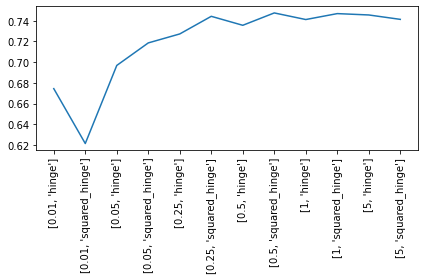

In [31]:
tfidf_svms('augmented_train_data.csv', labels=[1,2,3,4,5,6], max_features = True, remove_other = True)

### Further balancing the classes and undersampling the class 'other'

c, loss: 0.01 hinge   accuracy: 0.6619237336368811
Accuracy: 0.6619237336368811

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      2006
           1       0.77      0.46      0.58      1287
           2       0.62      0.68      0.65       839
           3       0.81      0.60      0.69       852
           4       0.69      0.67      0.68      1912
           5       0.77      0.67      0.72       886
           6       0.59      0.63      0.61      1003

    accuracy                           0.66      8785
   macro avg       0.69      0.65      0.66      8785
weighted avg       0.68      0.66      0.66      8785

c, loss: 0.01 squared_hinge   accuracy: 0.6252703471826978
Accuracy: 0.6252703471826978

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.87      0.65      2006
           1       0.70      0.43      0.53      1287
           2       0.63 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.05 hinge   accuracy: 0.673762094479226
Accuracy: 0.673762094479226

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.82      0.68      2006
           1       0.78      0.47      0.59      1287
           2       0.62      0.70      0.66       839
           3       0.82      0.63      0.71       852
           4       0.71      0.68      0.69      1912
           5       0.77      0.69      0.73       886
           6       0.65      0.64      0.64      1003

    accuracy                           0.67      8785
   macro avg       0.70      0.66      0.67      8785
weighted avg       0.69      0.67      0.67      8785

c, loss: 0.05 squared_hinge   accuracy: 0.6990324416619237
Accuracy: 0.6990324416619237

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.85      0.70      2006
           1       0.75      0.55      0.63      1287
           2       0.69   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.7005122367672169
Accuracy: 0.7005122367672169

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.83      0.70      2006
           1       0.79      0.53      0.63      1287
           2       0.66      0.76      0.70       839
           3       0.80      0.68      0.74       852
           4       0.75      0.68      0.71      1912
           5       0.78      0.72      0.75       886
           6       0.69      0.66      0.68      1003

    accuracy                           0.70      8785
   macro avg       0.72      0.69      0.70      8785
weighted avg       0.72      0.70      0.70      8785

c, loss: 0.25 squared_hinge   accuracy: 0.7197495731360273
Accuracy: 0.7197495731360273

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.82      0.71      2006
           1       0.76      0.60      0.67      1287
           2       0.74 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.7079112122936824
Accuracy: 0.7079112122936824

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71      2006
           1       0.78      0.55      0.65      1287
           2       0.69      0.77      0.73       839
           3       0.81      0.69      0.75       852
           4       0.75      0.68      0.71      1912
           5       0.77      0.72      0.75       886
           6       0.70      0.68      0.69      1003

    accuracy                           0.71      8785
   macro avg       0.73      0.70      0.71      8785
weighted avg       0.72      0.71      0.71      8785

c, loss: 0.5 squared_hinge   accuracy: 0.7192942515651679
Accuracy: 0.7192942515651679

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.81      0.71      2006
           1       0.75      0.61      0.68      1287
           2       0.75   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.71371656232214
Accuracy: 0.71371656232214

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.82      0.71      2006
           1       0.77      0.58      0.66      1287
           2       0.71      0.77      0.74       839
           3       0.79      0.72      0.75       852
           4       0.76      0.68      0.72      1912
           5       0.77      0.73      0.75       886
           6       0.70      0.68      0.69      1003

    accuracy                           0.71      8785
   macro avg       0.73      0.71      0.72      8785
weighted avg       0.72      0.71      0.71      8785

c, loss: 1 squared_hinge   accuracy: 0.7180421172453045
Accuracy: 0.7180421172453045

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      2006
           1       0.74      0.62      0.68      1287
           2       0.76      0.78 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.7126920887877063
Accuracy: 0.7126920887877063

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.78      0.71      2006
           1       0.74      0.60      0.66      1287
           2       0.73      0.79      0.76       839
           3       0.77      0.71      0.74       852
           4       0.75      0.69      0.72      1912
           5       0.76      0.73      0.75       886
           6       0.70      0.69      0.69      1003

    accuracy                           0.71      8785
   macro avg       0.73      0.71      0.72      8785
weighted avg       0.72      0.71      0.71      8785

c, loss: 5 squared_hinge   accuracy: 0.708252703471827
Accuracy: 0.708252703471827

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      2006
           1       0.73      0.61      0.66      1287
           2       0.77      0.7

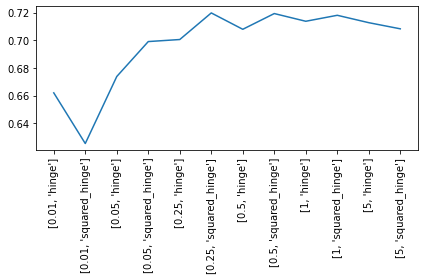

In [30]:
tfidf_svms('augmented_train_data2.csv', labels=[0,1,2,3,4,5,6], max_features = True, undersampling = 24000)

### Further balancing the classes and totally removing the class 'other'

c, loss: 0.01 hinge   accuracy: 0.682339112547752
Accuracy: 0.682339112547752

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.47      0.59      1231
           2       0.65      0.69      0.67       896
           3       0.84      0.59      0.69       893
           4       0.63      0.92      0.75      1824
           5       0.77      0.62      0.69       889
           6       0.62      0.66      0.64      1073

    accuracy                           0.68      6806
   macro avg       0.72      0.66      0.67      6806
weighted avg       0.71      0.68      0.68      6806

c, loss: 0.01 squared_hinge   accuracy: 0.6582427270055833
Accuracy: 0.6582427270055833

Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.50      0.56      1231
           2       0.67      0.64      0.65       896
           3       0.87      0.47      0.61       893
           4       0.58   

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.25 hinge   accuracy: 0.7497796062297972
Accuracy: 0.7497796062297972

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.56      0.66      1231
           2       0.68      0.77      0.72       896
           3       0.82      0.69      0.75       893
           4       0.73      0.92      0.82      1824
           5       0.80      0.75      0.78       889
           6       0.73      0.71      0.72      1073

    accuracy                           0.75      6806
   macro avg       0.76      0.73      0.74      6806
weighted avg       0.76      0.75      0.75      6806

c, loss: 0.25 squared_hinge   accuracy: 0.7719659124302086
Accuracy: 0.7719659124302086

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.65      0.69      1231
           2       0.75      0.77      0.76       896
           3       0.83      0.72      0.77       893
           4       0.77 

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 0.5 hinge   accuracy: 0.7628563032618279
Accuracy: 0.7628563032618279

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.59      0.67      1231
           2       0.72      0.77      0.75       896
           3       0.82      0.73      0.77       893
           4       0.75      0.91      0.82      1824
           5       0.81      0.78      0.79       889
           6       0.73      0.72      0.72      1073

    accuracy                           0.76      6806
   macro avg       0.77      0.75      0.75      6806
weighted avg       0.77      0.76      0.76      6806

c, loss: 0.5 squared_hinge   accuracy: 0.775639141933588
Accuracy: 0.775639141933588

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.65      0.69      1231
           2       0.76      0.78      0.77       896
           3       0.81      0.72      0.76       893
           4       0.78     

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 1 hinge   accuracy: 0.769761974728181
Accuracy: 0.769761974728181

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.61      0.68      1231
           2       0.74      0.78      0.76       896
           3       0.81      0.73      0.77       893
           4       0.77      0.91      0.83      1824
           5       0.82      0.77      0.79       889
           6       0.73      0.73      0.73      1073

    accuracy                           0.77      6806
   macro avg       0.77      0.76      0.76      6806
weighted avg       0.77      0.77      0.77      6806

c, loss: 1 squared_hinge   accuracy: 0.7751983543931825
Accuracy: 0.7751983543931825

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.65      0.69      1231
           2       0.77      0.79      0.78       896
           3       0.81      0.72      0.77       893
           4       0.78      0.9

G:\Anaconda\envs\TextMining\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c, loss: 5 hinge   accuracy: 0.7669703203056127
Accuracy: 0.7669703203056127

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.62      0.68      1231
           2       0.76      0.79      0.77       896
           3       0.79      0.73      0.76       893
           4       0.79      0.89      0.83      1824
           5       0.80      0.76      0.78       889
           6       0.71      0.75      0.73      1073

    accuracy                           0.77      6806
   macro avg       0.77      0.76      0.76      6806
weighted avg       0.77      0.77      0.76      6806

c, loss: 5 squared_hinge   accuracy: 0.76888039964737
Accuracy: 0.76888039964737

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.65      0.69      1231
           2       0.77      0.81      0.79       896
           3       0.80      0.72      0.76       893
           4       0.78      0.88 

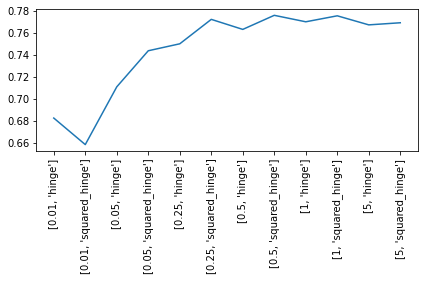

In [32]:
tfidf_svms('augmented_train_data2.csv', labels=[1,2,3,4,5,6], max_features = True, remove_other = True)

### Plotting the confusion matrix for the best performing parameters for the SVM


Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.67      0.71      1231
           2       0.77      0.79      0.78       896
           3       0.82      0.73      0.78       893
           4       0.79      0.91      0.85      1824
           5       0.84      0.78      0.81       889
           6       0.75      0.75      0.75      1073

    accuracy                           0.79      6806
   macro avg       0.79      0.77      0.78      6806
weighted avg       0.79      0.79      0.78      6806



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

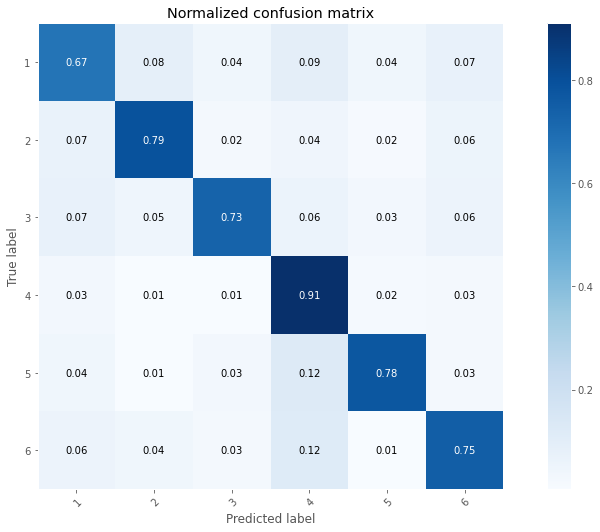

In [250]:
data = pd.read_csv(data_folder + 'augmented_train_data2.csv').fillna('')
data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
    
    # drop empty rows
data = data[data['Sentence'].map(lambda d: len(d)) > 0]
    
data = data[data.Emotion != 0]
    # split train-test data
    
X_train, X_test, y_train, y_test = train_test_split(data.Sentence, data.Emotion, train_size = 0.9, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
    

tfidf_vectorizer = TfidfVectorizer()
    
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test = tfidf_vectorizer.transform(X_test).toarray()
X_val = tfidf_vectorizer.transform(X_val).toarray()

svm_model1 = LinearSVC(random_state=0, penalty =  'l2', loss='squared_hinge', C=0.5)
svm_model1.fit(X_train, y_train)
y_pred = svm_model1.predict(X_val)
               
accuracy = svm_model1.score(X_val, y_val)
                
               
print('\nClassification Report:')
print(classification_report(y_val, y_pred, labels=[1,2,3,4,5,6]))
               
plot_confusion_matrix(y_val, y_pred, classes = [1,2,3,4,5,6], normalize=True, title='Normalized confusion matrix')
#plot_confusion_matrix(y_test, y_pred, classes = [class_names[x] for x in labels], normalize=True, title='Normalized confusion matrix')
                    


# Word Embeddings and bi-directional LSTMs

### For the creation of te word embeddings, Glove's pretrained model was used

##### In the following experiments, there will be an evaluation of the difference on the performance of the model caused by the different preprocessing techniques imposed on the initial training dataset. More precisely, the aspects that will be tested are the following:

- Without negation handling
- With negation handling
- With data augmentation
- With data augmentation and removal of the class 'other'
- Not removing the stopwords

# Calculate number of tokens distribution 

For the creation of the embeddings, all the vectors need to have the same dimension. For this reason a maximum number of tokens need be defined. If this number is too large, all shorter sentences will have their empty dimensions replaced by 0. This procedure is called 'zero padding'. However, if too many 0s are inserted, then bias will be introduced and the model will not be able to learn the correct representations. By calculating the distribution of the frequency of tokens of different lengths on the Game of Thrones corpus, it can be observed that more than 80\% of the sentences consist of less than 40 tokens. On the other hand, there are some extremely few cases consisting of up to 700 tokens. These cases are considered as outliers and will be ignored, since if sentences with 700 tokens are taken into account, then for the creation of the embeddings, all other sentences will have to be brought to the same dimension by adding 0s. This would result into 80\% being represented by 40 numbers and 660 0s, thus the model's performance would dramatically be reduced. For this reason, the maximum number of tokens will be trimmed to 40. 

In [180]:
corpus= pd.read_csv(data_folder + 'preprocessed_corpus.csv')
corpus.head()

,Season,Sentence,Name
0,Season 1,d’you expect they ’re savage one lot steal goat another lot know they ’re rip piece,waymar royce
1,Season 1,’ve never see wildling thing like ’ve never see thing like ever life,will
2,Season 1,close get,waymar royce
3,Season 1,close man would,will
4,Season 1,head back wall,gared


In [181]:
def count_tokens(sentence):
    counter = 0
    for token in sentence:
        if token != ' ':
            counter += 1
            
    return counter

In [182]:
corpus['token_counts'] = corpus.Sentence.apply(count_tokens)

In [183]:
corpus.token_counts.describe()

count    21501.000000
mean        30.834426
std         37.433028
min          3.000000
25%         10.000000
50%         19.000000
75%         38.000000
max        727.000000
Name: token_counts, dtype: float64

In [184]:
corpus.token_counts.value_counts()[:35]

4     1176
8      888
5      746
9      727
7      682
10     667
12     638
13     627
14     607
11     603
3      592
15     584
16     527
6      503
17     473
18     471
19     420
20     404
21     372
23     366
22     354
24     340
25     334
27     300
26     297
28     281
29     281
30     273
34     241
31     232
33     230
36     222
35     221
32     213
38     191
Name: token_counts, dtype: int64

In [54]:
corpus.token_counts.value_counts()[:35].sum()

16083

<AxesSubplot:ylabel='Frequency'>

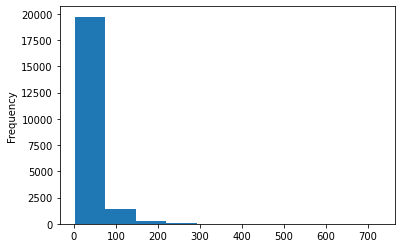

In [21]:
corpus.token_counts.plot(kind='hist')

In [47]:
# Function to run the bidirectional lstm on different datasets and with different hyperparameters
def bilstm(filename, labels, remove_other = False, undersampling = 0, lr = 1e-3, epochs = 15, batch = 128, plot_title = ''):
    
    # read dataset and replace emotion strings with numbers
    data = pd.read_csv(data_folder + filename).fillna('')
    data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
    
    # drop empty rows
    data = data[data['Sentence'].map(lambda d: len(d)) > 0]
    
    # undersample class 'other'
    if remove_other:
        data = data[data.Emotion != 0]
    elif undersampling > 0:
        data = data.drop(data[data.Emotion == 0].sample(undersampling).index)
    
    # train the embeddings tokenizer
    tokenizer = Tokenizer(nb_words = MAX_NB_WORDS)
    tokenizer.fit_on_texts(data.Sentence)
    print('Found %s unique tokens.' % len(tokenizer.word_index))
    
    X_train, X_test, y_train, y_test = train_test_split(data.Sentence, data.Emotion, train_size = 0.8)
    
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    index_of_words = tokenizer.word_index

    # vacab size is number of unique words + reserved 0 index for padding
    vocab_size = len(index_of_words) + 1

    # print('Number of unique words: {}'.format(len(index_of_words)))
    
    X_train_pad = pad_sequences(X_train, maxlen = 40 )
    X_test_pad = pad_sequences(X_test, maxlen = 40 )

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    num_words = min(MAX_NB_WORDS, len(tokenizer.word_index)) + 1
    print(num_words)

    # first create a matrix of zeros, this is our embedding matrix
    embedding_matrix = np.zeros((num_words, embedding_dim))

    # for each word in out tokenizer lets try to find that work in our w2v model
    for word, i in tokenizer.word_index.items():
        if i > MAX_NB_WORDS:
            continue
            
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # we found the word - add that words vector to the matrix
            embedding_matrix[i] = embedding_vector
        else:
            # doesn't exist, assign a random vector
            embedding_matrix[i] = np.random.randn(embedding_dim)
            
    
    embedd_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length = 40, weights = [embedding_matrix], trainable=False)
    
    output_size = 128
    
    # Embedding Layer, biLSTM, Dense, softmax
    model = Sequential()
    model.add(embedd_layer)   
    model.add(Bidirectional(LSTM(units=output_size, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(7, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr, decay=(lr/epochs)), metrics=['accuracy'])
    model.summary()

    hist = model.fit(X_train_pad, y_train, 
                     batch_size=batch,
                     epochs=epochs,
                     validation_data=(X_test_pad, y_test))
    
    y_pred = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred, axis=1)
    
    y_test = np.argmax(y_test, axis=1)

    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=[class_names[x] for x in labels], normalize=True)
    
    # , title='Normalized confusion matrix'
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), hist.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), hist.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), hist.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), hist.history["val_accuracy"], label="val_acc")
    plt.title(plot_title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy/Loss")
    plt.legend(loc="upper right")
    plt.show()

### In this first experiment, neither negation handling, nor augmentation is performed

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 24395 unique tokens.
24396
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 40, 300)           7318800   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 1799      
Total params: 7,759,895
Trainable params: 441,095
Non-trainable params: 7,318,800
_________________________________________________________________
Train on 70396 samples, validate on 17600 samples
Epoch 1/15
70396/70396 [==============================] - 24s 339us/step - loss: 0.9967 - accuracy: 0.6661 - val_loss: 0.8511 - val_accuracy: 0.7139
Epoch 2/15
70396/70396 [==============================] - 23s 330us/step - loss: 0.8119 - accuracy: 0.7273 - val_loss: 0.7864 - val_acc

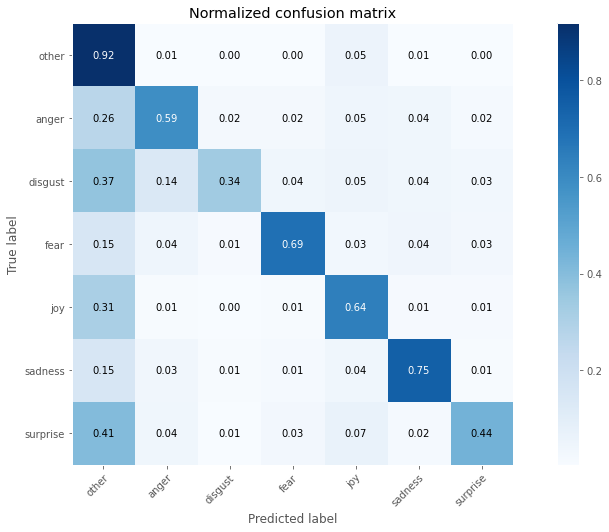

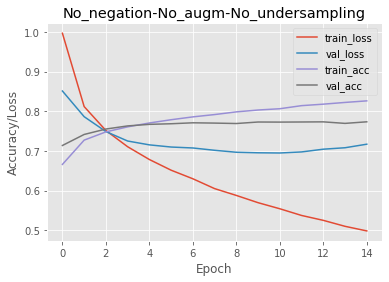

In [240]:
bilstm('preprocessed_basic_train_data.csv', labels=[0,1,2,3,4,5,6], lr = 1e-3, epochs = 15, batch = 128, plot_title = 'No_negation-No_augm-No_undersampling')

### The difference from the previous run is that these results will measure the effect of negation handling

It can be observed that negation handling indeed, slightly improves the results.

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 24460 unique tokens.
24461
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 40, 300)           7338300   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 1799      
Total params: 7,779,395
Trainable params: 441,095
Non-trainable params: 7,338,300
_________________________________________________________________
Train on 70396 samples, validate on 17600 samples
Epoch 1/15
70396/70396 [==============================] - 24s 339us/step - loss: 0.9954 - accuracy: 0.6675 - val_loss: 0.8318 - val_accuracy: 0.7216
Epoch 2/15
70396/70396 [==============================] - 23s 329us/step - loss: 0.8165 - accuracy: 0.7263 - val_loss: 0.7720 - val_acc

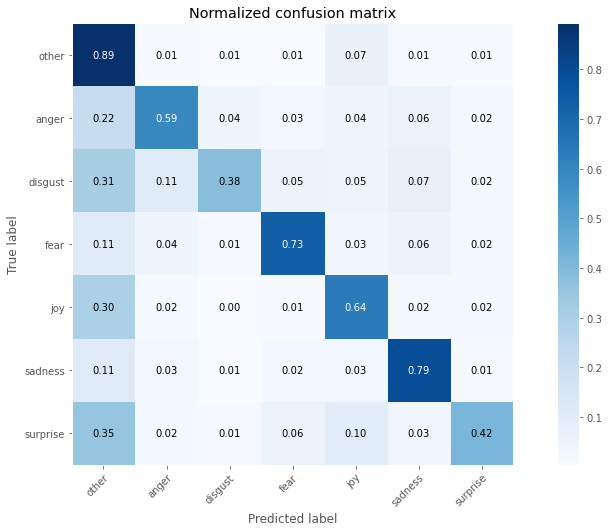

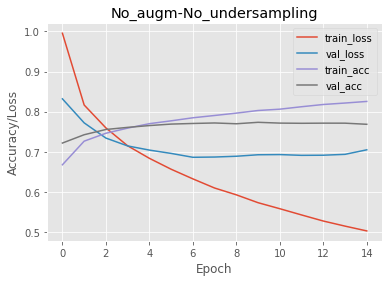

In [242]:
bilstm('preprocessed_train_data.csv', labels=[0,1,2,3,4,5,6], lr = 1e-3, epochs = 15, batch = 128, plot_title = 'No_augm-No_undersampling')

### Measuring the effect of data augmentation

In this case the classes are not totally balanced

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 26415 unique tokens.
26416
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 40, 300)           7924800   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_29 (Dense)             (None, 7)                 1799      
Total params: 8,365,895
Trainable params: 441,095
Non-trainable params: 7,924,800
_________________________________________________________________
Train on 84559 samples, validate on 21140 samples
Epoch 1/15
84559/84559 [==============================] - 29s 339us/step - loss: 1.0853 - accuracy: 0.6218 - val_loss: 0.9198 - val_accuracy: 0.6857
Epoch 2/15
84559/84559 [==============================] - 28s 331us/step - loss: 0.8842 - accuracy: 0.6951 - val_loss: 0.8323 - val_acc

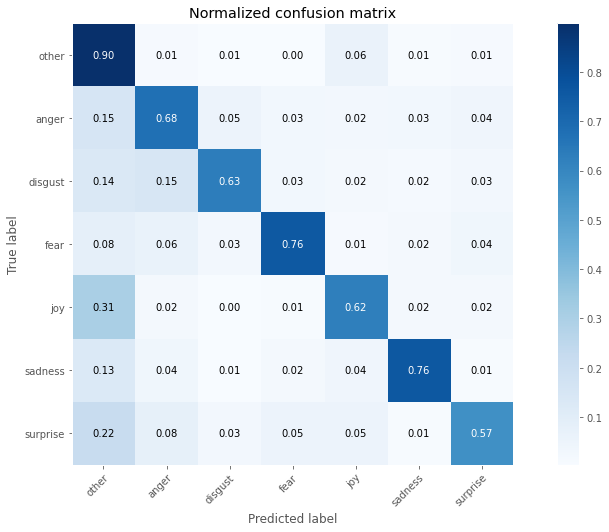

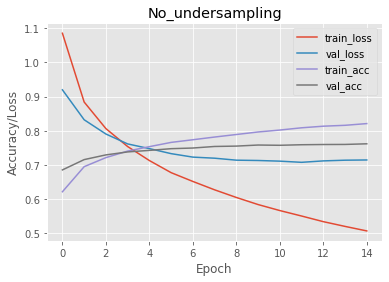

In [243]:
bilstm('augmented_train_data.csv', labels=[0,1,2,3,4,5,6], lr = 1e-3, epochs = 15, batch = 128, plot_title = 'No_undersampling')

### Removing the class 'other'

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 21421 unique tokens.
21422
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 40, 300)           6426600   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_30 (Dense)             (None, 7)                 1799      
Total params: 6,867,695
Trainable params: 441,095
Non-trainable params: 6,426,600
_________________________________________________________________
Train on 49364 samples, validate on 12341 samples
Epoch 1/15
49364/49364 [==============================] - 17s 349us/step - loss: 1.1590 - accuracy: 0.5596 - val_loss: 0.9349 - val_accuracy: 0.6545
Epoch 2/15
49364/49364 [==============================] - 17s 339us/step - loss: 0.8926 - accuracy: 0.6735 - val_loss: 0.8205 - val_acc

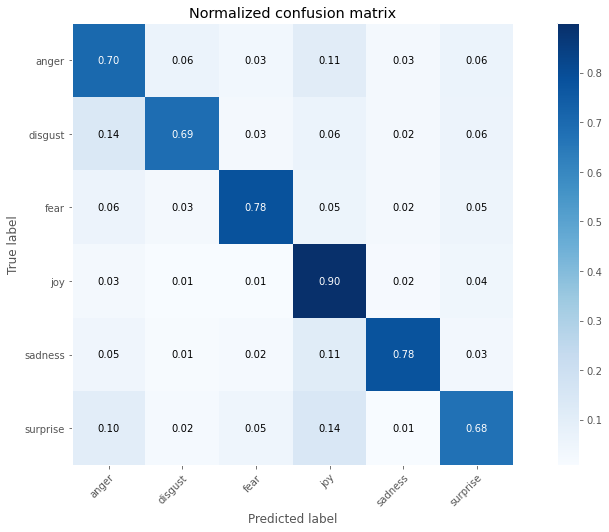

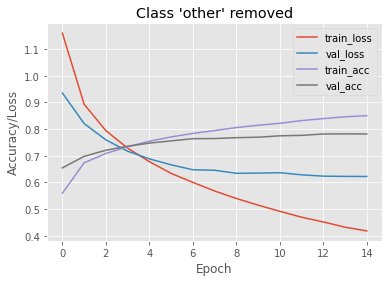

In [244]:
bilstm('augmented_train_data.csv', labels = [1,2,3,4,5,6], remove_other = True, lr = 1e-3, epochs = 15, batch = 128, plot_title = "Class 'other' removed")

#### Augmenting the data so that all classes are relatively equally balanced, class 'other' is again removed

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 21459 unique tokens.
21460
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 40, 300)           6438000   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_31 (Dense)             (None, 7)                 1799      
Total params: 6,879,095
Trainable params: 441,095
Non-trainable params: 6,438,000
_________________________________________________________________
Train on 54990 samples, validate on 13748 samples
Epoch 1/15
54990/54990 [==============================] - 19s 350us/step - loss: 1.1747 - accuracy: 0.5559 - val_loss: 0.9280 - val_accuracy: 0.6530
Epoch 2/15
54990/54990 [==============================] - 19s 342us/step - loss: 0.8939 - accuracy: 0.6703 - val_loss: 0.7954 - val_acc

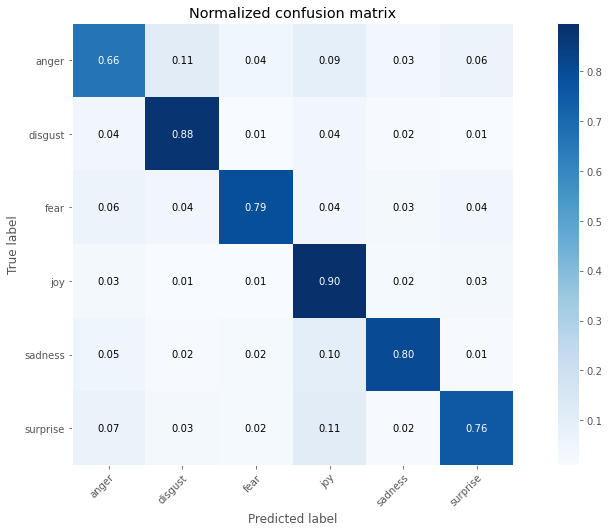

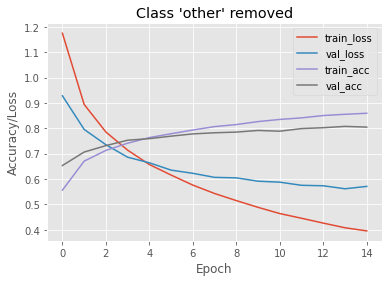

In [245]:
bilstm('augmented_train_data2.csv', labels = [1,2,3,4,5,6], remove_other = True, lr = 1e-3, epochs = 15, batch = 128, plot_title = "Class 'other' removed")

#### Another aspect that is investigated is the removal of stopwords. Since bi-directional LSTMs are able to capture the semantic context of the sentences, it is not clear yet if their removal benefits or harms the performance of the model.  In this case, the stopwords are not removed, while the class 'other' is removed.

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 21110 unique tokens.
21111
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 40, 300)           6333300   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_32 (Dense)             (None, 7)                 1799      
Total params: 6,774,395
Trainable params: 441,095
Non-trainable params: 6,333,300
_________________________________________________________________
Train on 55735 samples, validate on 13934 samples
Epoch 1/15
55735/55735 [==============================] - 19s 347us/step - loss: 1.2127 - accuracy: 0.5389 - val_loss: 0.9555 - val_accuracy: 0.6492
Epoch 2/15
55735/55735 [==============================] - 19s 336us/step - loss: 0.9074 - accuracy: 0.6695 - val_loss: 0.7969 - val_acc

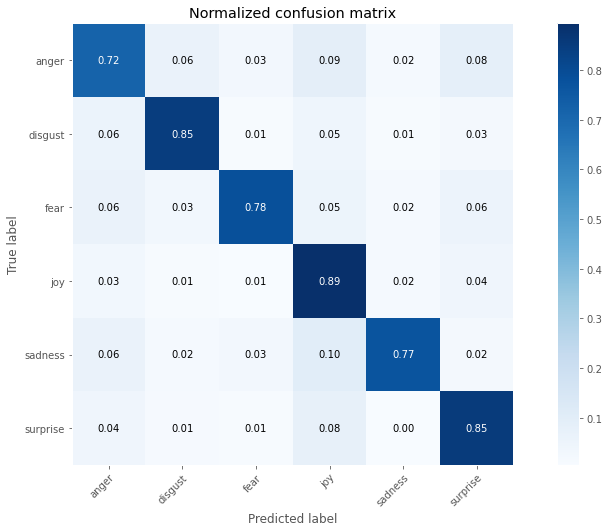

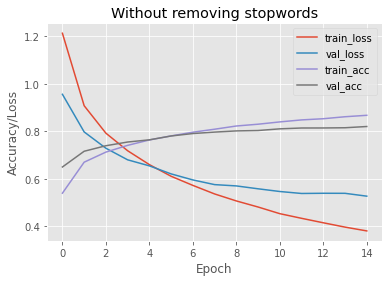

In [246]:
bilstm('augmented_train_data3.csv', labels = [1,2,3,4,5,6], remove_other = True, lr = 1e-3, epochs = 15, batch = 128, plot_title = "Without removing stopwords")

### In this case, the stopwords are not removed and also the class other is not removed, but undersampled.

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 23844 unique tokens.
23845
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 300)           7153500   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 1799      
Total params: 7,594,595
Trainable params: 441,095
Non-trainable params: 7,153,500
_________________________________________________________________
Train on 72396 samples, validate on 18099 samples
Epoch 1/15
72396/72396 [==============================] - 29s 399us/step - loss: 1.2734 - accuracy: 0.5276 - val_loss: 1.0387 - val_accuracy: 0.6211
Epoch 2/15
72396/72396 [==============================] - 24s 337us/step - loss: 1.0002 - accuracy: 0.6387 - val_loss: 0.9042 - val_accu

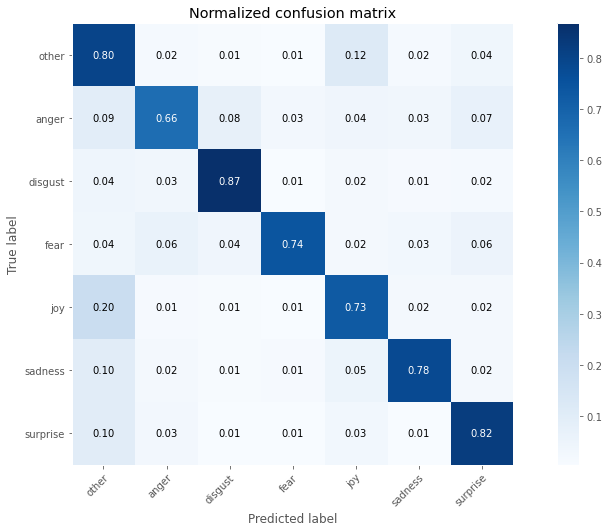

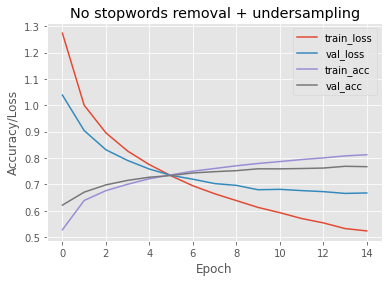

In [50]:
bilstm('augmented_train_data3.csv', labels=[0,1,2,3,4,5,6], undersampling = 24000, lr = 1e-3, epochs = 15, batch = 128, plot_title = 'No stopwords removal + undersampling')

## Annotate Corpus using the best model

From the analysis of all the models that were tested and all the different degrees of preprocessing, it is concluded that the best performing approach is to use the bi-directional LSTMs, without removing the stopwords and equally balancing the classes with augmentation. What is not perfectly clear is whether the class 'other' shuold just be undersampled, or totally removed. Both approaches's performance will be tested by calculating the Kappa score on the predictions made on the GoT corpus.

The whole training dataset will be used to train the model, and predictions will be made on the Game of Thrones corpus. Before performing the predictions, the GoT corpus will have to undergo the same preprocessing that was imposed on the training set. More precisely, conversion to lowercase, punctuation removal, lemmatization and negation handling. Stopwords will not be removed from the corpus as well.

In [77]:
# Preprocessing the GoT corpus

corpus = pd.read_csv(data_folder + 'got_corpus.csv', delimiter=';')
corpus = corpus.drop(['Column1', 'Emision Date', 'Episode', 'N_Season','N_serie'], axis = 1) 
corpus['Season'] = corpus['Season'].str.replace('Season','')
corpus['Season'] = corpus['Season'].astype(int)
corpus.head()

,Season,Sentence,Name
0,1,"What d’you expect? They’re savages One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces",waymar royce
1,1,"I’ve never seen wildlings do a thing like this I’ve never seen a thing like this, not ever in my life",will
2,1,How close did you get?,waymar royce
3,1,Close as any man would,will
4,1,We should head back to the wall,gared


In [24]:
def preprocessing3(sentence):
    # convert to lowercase
    sentence = sentence.lower()    
    
    # remove punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]
    sentence = ''.join(nopunc)
    
#     # remove stopwords
#     sentence = ' '.join([word for word in sentence.split() if word not in my_stopwords]) 
    
    # lemmatization
    doc = nlp(sentence)
    sentence = [token.lemma_ if ('PRON' not in token.lemma_) & (len(token.lemma_) > 2) else '' for token in doc]
        
    # remove empty tokens
    sentence = list(filter(('').__ne__, sentence))

    # negation handling
    antonyms = {}
    for idx, (first, second) in enumerate(zip(sentence, sentence[1:])):
        if first == 'not':
            antonyms[idx-len(antonyms.keys())] = negation_handling(second)
            
    for key in antonyms.keys():
        sentence[key] = antonyms[key]
        sentence.pop(key+1)
        
    return ' '.join([word for word in sentence])

In [82]:
corpus['Sentence'] = corpus.Sentence.apply(preprocessing3)

In [83]:
corpus = corpus[corpus['Sentence'].map(lambda d: len(d)) > 0]
corpus.head()

,Season,Sentence,Name
0,1,what d’you expect they ’re savage one lot steal goat from another lot and before you know they ’re rip each other piece,waymar royce
1,1,’ve never see wildling thing like this ’ve never see thing like this ever life,will
2,1,how close you get,waymar royce
3,1,close any man would,will
4,1,should head back the wall,gared


In [84]:
corpus.to_csv(data_folder + 'corpus_final.csv', index = False)

In [4]:
lr = 1e-3
epochs = 15
batch = 128

In [93]:
freq = corpus.groupby('Season').Emotion.value_counts().to_frame(name='Frequency').reset_index()

In [94]:
alt.Chart(freq).mark_area().encode(
    alt.X('Season:Q', axis=alt.Axis(domain=False, tickSize=5, grid=True)),
    alt.Y('Frequency:Q', stack='center', axis=None),
    alt.Color('Emotion:N',scale=alt.Scale(scheme='category20b'))
).interactive()

alt.Chart(...)

# Undersampling class 'other'

In [2]:
corpus = pd.read_csv(data_folder + 'corpus_final.csv')

In [39]:
# Read dataset and replace emotion strings with numbers
data = pd.read_csv(data_folder + 'augmented_train_data3.csv').fillna('')
data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
    
# Drop empty rows
data = data[data['Sentence'].map(lambda d: len(d)) > 0]
    
data = data.drop(data[data.Emotion == 0].sample(24000).index)
    
# Train the embeddings tokenizer
tokenizer = Tokenizer(nb_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(data.Sentence)
print('Found %s unique tokens.' % len(tokenizer.word_index))
    
X_train = data.Sentence
y_train = data.Emotion
X_test = corpus.Sentence
    
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


index_of_words = tokenizer.word_index

# Vocab size is the number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

X_train_pad = pad_sequences(X_train, maxlen = 40 )
X_test_pad = pad_sequences(X_test, maxlen = 40 )

y_train = to_categorical(y_train)
    
num_words = min(MAX_NB_WORDS, len(tokenizer.word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in tokenizer.word_index.items():
    if i > MAX_NB_WORDS:
        continue
            
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
    # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)
            
    
embedd_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length = 40, weights = [embedding_matrix], trainable=False)
    
output_size = 128
    
# Embedding Layer, biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)   
model.add(Bidirectional(LSTM(units=output_size, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(7, activation='softmax'))   
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr, decay=(lr/epochs)), metrics=['accuracy'])
model.summary()

hist = model.fit(X_train_pad, y_train, 
                    batch_size=batch,
                     epochs=epochs)

#     ,validation_data=(X_test_pad, y_test)
    
y_pred = model.predict(X_test_pad)
y_pred = np.argmax(y_pred, axis=1)

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 23819 unique tokens.
23820
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           7146000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 7,587,095
Trainable params: 441,095
Non-trainable params: 7,146,000
_________________________________________________________________
Epoch 1/15
90495/90495 [==============================] - 33s 363us/step - loss: 1.2257 - accuracy: 0.5483
Epoch 2/15
90495/90495 [==============================] - 28s 308us/step - loss: 0.9615 - accuracy: 0.6516
Epoch 3/15
90495/90495 [==============================] - 28s 307us/step - loss: 0.8570 - accuracy: 0.6911
Epoch 4/15
904

In [40]:
corpus['Emotion'] = y_pred

In [41]:
corpus['Emotion'].replace({0: "other", 1 : "anger", 2 : "disgust", 3 : "fear", 4 : "joy", 5 : "sadness", 6 : "surprise"}, inplace = True)

In [42]:
# these will be used to retrieve the predicted classes and compare them with the manual annotations 
corpus.head(50)

,Season,Sentence,Name,Emotion
0,1,what d’you expect they ’re savage one lot steal goat from another lot and before you know they ’re rip each other piece,waymar royce,surprise
1,1,’ve never see wildling thing like this ’ve never see thing like this ever life,will,joy
2,1,how close you get,waymar royce,other
3,1,close any man would,will,anger
4,1,should head back the wall,gared,other
5,1,the dead frighten you,royce,fear
6,1,our order track the wildling track they they n’t trouble more,gared,other
7,1,you n’t think ’ll ask how they die get back your horse,royce,other
8,1,whatever they could they even kill the child,will,other
9,1,good thing ’re child you want run away south run away course they will behead you deserter n’t catch you first get back your horse n’t say again,royce,joy


In [43]:
corpus.tail(50)

,Season,Sentence,Name,Emotion
22144,7,tell you one walk away from,cersei,other
22145,7,you order kill the only one you have leave our child,jaime,surprise
22146,7,there one more yet come,cersei,other
22147,7,give the order then,jaime,other
22148,7,believe you,jaime,surprise
22149,7,come,bran,joy
22150,7,samwell tarly,bran,anger
22151,7,sure you remember,sam,other
22152,7,remember everything,bran,other
22153,7,you help get beyond the wall you good man,bran,joy


###### Plotting the results

In [45]:
freq = corpus.groupby('Season').Emotion.value_counts().to_frame(name='Frequency').reset_index()

In [46]:
alt.Chart(freq).mark_area().encode(
    alt.X('Season:Q', axis=alt.Axis(domain=False, tickSize=5, grid=True)),
    alt.Y('Frequency:Q', stack='center', axis=None),
    alt.Color('Emotion:N',scale=alt.Scale(scheme='category20b'))
).interactive()

alt.Chart(...)

# Removing class 'other'

In [5]:
# Read dataset and replace emotion strings with numbers
data = pd.read_csv(data_folder + 'augmented_train_data3.csv').fillna('')
data['Emotion'].replace({"other" : 0, "anger" : 1, "disgust" : 2, "fear" : 3, "joy" : 4, "sadness" : 5, "surprise" : 6}, inplace = True)
    
# Drop empty rows
data = data[data['Sentence'].map(lambda d: len(d)) > 0]
    
data = data.drop(data[data.Emotion == 0].sample(44826).index)
    
# Train the embeddings tokenizer
tokenizer = Tokenizer(nb_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(data.Sentence)
print('Found %s unique tokens.' % len(tokenizer.word_index))
    
X_train = data.Sentence
y_train = data.Emotion
X_test = corpus.Sentence
    
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


index_of_words = tokenizer.word_index

# Vocab size is the number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

X_train_pad = pad_sequences(X_train, maxlen = 40 )
X_test_pad = pad_sequences(X_test, maxlen = 40 )

y_train = to_categorical(y_train)
    
num_words = min(MAX_NB_WORDS, len(tokenizer.word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in tokenizer.word_index.items():
    if i > MAX_NB_WORDS:
        continue
            
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
    # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)
            
    
embedd_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length = 40, weights = [embedding_matrix], trainable=False)
    
output_size = 128
    
# Embedding Layer, biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)   
model.add(Bidirectional(LSTM(units=output_size, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(7, activation='softmax'))   
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr, decay=(lr/epochs)), metrics=['accuracy'])
model.summary()

hist = model.fit(X_train_pad, y_train, 
                    batch_size=batch,
                     epochs=epochs)

#     ,validation_data=(X_test_pad, y_test)
    
y_pred = model.predict(X_test_pad)
y_pred = np.argmax(y_pred, axis=1)

G:\Anaconda\envs\tf-gpu\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 21110 unique tokens.
21111
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 300)           6333300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 6,774,395
Trainable params: 441,095
Non-trainable params: 6,333,300
_________________________________________________________________
Epoch 1/15
69669/69669 [==============================] - 22s 321us/step - loss: 1.1619 - accuracy: 0.5602
Epoch 2/15
69669/69669 [==============================] - 22s 311us/step - loss: 0.8593 - accuracy: 0.6860
Epoch 3/15
69669/69669 [==============================] - 22s 311us/step - loss: 0.7500 - accuracy: 0.7267
Epoch 4/15
696

In [6]:
corpus['Emotion'] = y_pred

In [7]:
corpus['Emotion'].replace({0: "other", 1 : "anger", 2 : "disgust", 3 : "fear", 4 : "joy", 5 : "sadness", 6 : "surprise"}, inplace = True)

In [8]:
corpus.head(50)

,Season,Sentence,Name,Emotion
0,1,what d’you expect they ’re savage one lot steal goat from another lot and before you know they ’re rip each other piece,waymar royce,anger
1,1,’ve never see wildling thing like this ’ve never see thing like this ever life,will,joy
2,1,how close you get,waymar royce,joy
3,1,close any man would,will,anger
4,1,should head back the wall,gared,joy
5,1,the dead frighten you,royce,fear
6,1,our order track the wildling track they they n’t trouble more,gared,joy
7,1,you n’t think ’ll ask how they die get back your horse,royce,surprise
8,1,whatever they could they even kill the child,will,anger
9,1,good thing ’re child you want run away south run away course they will behead you deserter n’t catch you first get back your horse n’t say again,royce,joy


In [9]:
corpus.tail(50)

,Season,Sentence,Name,Emotion
22144,7,tell you one walk away from,cersei,anger
22145,7,you order kill the only one you have leave our child,jaime,surprise
22146,7,there one more yet come,cersei,joy
22147,7,give the order then,jaime,joy
22148,7,believe you,jaime,surprise
22149,7,come,bran,joy
22150,7,samwell tarly,bran,surprise
22151,7,sure you remember,sam,joy
22152,7,remember everything,bran,joy
22153,7,you help get beyond the wall you good man,bran,joy


###### Plotting the results

In [10]:
freq = corpus.groupby('Season').Emotion.value_counts().to_frame(name='Frequency').reset_index()

In [11]:
alt.Chart(freq).mark_area().encode(
    alt.X('Season:Q', axis=alt.Axis(domain=False, tickSize=5, grid=True)),
    alt.Y('Frequency:Q', stack='center', axis=None),
    alt.Color('Emotion:N',scale=alt.Scale(scheme='category20b'))
).interactive()

alt.Chart(...)

# Evaluation of the results

In order to evaluate the results of Emotion mining 100 sentences will be annotated manually by two different annotators and the Kappa distance will be calculated.

In [15]:
evaluation = pd.read_csv(data_folder + "got_corpus.csv", delimiter=';')
evaluation.head(50)

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,"What d’you expect? They’re savages One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces",waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,"I’ve never seen wildlings do a thing like this I’ve never seen a thing like this, not ever in my life",will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011
5,6,Season 1,winter is coming,Do the dead frighten you?,royce,1,1,17/04/2011
6,7,Season 1,winter is coming,Our orders were to track the wildlings We tracked them They won’t trouble us no more,gared,1,1,17/04/2011
7,8,Season 1,winter is coming,You don’t think he’ll ask us how they died? Get back on your horse,royce,1,1,17/04/2011
8,9,Season 1,winter is coming,Whatever did it to them could do it to us They even killed the children,will,1,1,17/04/2011
9,10,Season 1,winter is coming,"It’s a good thing we’re not children You want to run away south, run away Of course, they will behead you as a deserter If I don’t catch you first Get back on your horse I won’t say it again",royce,1,1,17/04/2011


In [16]:
evaluation.tail(50)

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
22460,22461,Season 7,the dragon and the wolf,Are you going to order him to kill me? Im the only one you have left Our children are gone,jaime,67,7,27/08/2017
22461,22462,Season 7,the dragon and the wolf,Theres one more yet to come,cersei,67,7,27/08/2017
22462,22463,Season 7,the dragon and the wolf,"Give the order, then",jaime,67,7,27/08/2017
22463,22464,Season 7,the dragon and the wolf,I dont believe you,jaime,67,7,27/08/2017
22464,22465,Season 7,the dragon and the wolf,Come in,bran,67,7,27/08/2017
22465,22466,Season 7,the dragon and the wolf,Samwell Tarly,bran,67,7,27/08/2017
22466,22467,Season 7,the dragon and the wolf,I wasnt sure if youd remember me,sam,67,7,27/08/2017
22467,22468,Season 7,the dragon and the wolf,I remember everything,bran,67,7,27/08/2017
22468,22469,Season 7,the dragon and the wolf,You helped us get beyond the Wall Youre a good man,bran,67,7,27/08/2017
22469,22470,Season 7,the dragon and the wolf,"Oh, well, thank you, but, um, Im not sure that I am What happened to you beyond the Wall?",sam,67,7,27/08/2017


In [156]:
# Correspondence: other = 0, joy=1, anger=2, fear=3, surprise=4 ,disgust=5, sadness=6
# I print the lenghts to make sure that there were no mistakes, either by me or the other annotator

# Labels produced by the two annotators without using the class 'other'
annotator1_no_other = [2,1,1,1,3,3,2,3,2,2,2,3,4,4,2,1,1,1,1,1,2,2,1,1,2,2,3,1,4,4,6,2,6,2,3,6,6,2,2,2,2,1,6,2,2,5,1,3,2,3,2,1,5,2,4,1,4,1,1,6,4,3,4,3,6,4,6,4,6,2,2,1,3,4,1,1,2,2,4,1,6,6,4,1,1,1,1,4,1,1,1,2,3,1,6,5,3,3,4,1]
annotator2_no_other = [2,3,1,1,3,3,2,3,3,2,2,2,5,2,1,1,1,1,1,2,2,2,3,3,5,4,2,1,2,1,6,6,6,2,3,6,6,2,2,2,2,4,3,2,2,2,1,3,2,3,2,1,2,2,1,1,4,1,4,6,4,2,2,6,4,4,6,4,1,3,2,5,3,4,1,1,2,1,2,6,2,6,4,1,1,4,1,4,1,1,1,2,3,6,6,5,3,3,4,1]

print(len(annotator2_no_other))

# Labels produced by the two annotators by using the class 'other'
annotator1_other = [4,4,0,2,0,3,0,0,5,2,3,0,0,0,3,0,1,1,1,0,0,1,1,3,2,0,3,1,0,1,2,0,0,6,6,6,0,0,0,3,0,0,0,2,2,0,0,0,2,5,0,1,5,2,0,0,1,0,4,1,0,0,0,0,0,4,0,0,0,0,2,6,0,0,1,1,2,1,4,0,6,0,0,1,1,0,0,4,1,0,1,2,0,6,0,2,0,0,4,0]
annotator2_other = [4,3,0,0,0,3,0,3,3,2,0,0,0,0,3,0,0,1,1,0,2,1,0,3,2,0,2,1,0,0,2,0,0,3,6,0,0,0,0,6,2,0,0,2,0,0,0,3,2,5,2,1,2,2,0,0,4,0,4,6,0,0,0,0,0,0,0,0,0,0,2,6,0,4,1,1,2,6,2,0,2,0,4,0,1,0,0,4,4,0,1,2,0,6,0,0,0,0,4,3]

print(len(annotator1_other))
print(len(annotator2_other))

# Labels predicted by the LSTM with class 'other'
y_pred_other = [4,1,0,2,0,3,0,0,0,1,2,0,0,4,3,0,0,1,1,0,0,1,3,3,1,0,2,4,0,0,6,0,0,6,6,0,0,0,0,6,0,0,0,2,0,0,0,0,2,5,0,4,0,0,4,1,2,0,0,1,1,3,0,0,0,0,0,0,0,0,5,6,4,0,6,6,5,1,1,0,2,0,0,0,0,4,0,2,4,0,1,0,0,6,0,0,0,1,4,0]

print(len(y_pred_other))

# Labels predicted by the LSTM without class 'other'
y_pred_no_other = [2,1,1,2,1,3,1,4,2,1,2,1,1,4,2,1,1,1,1,2,1,1,3,3,5,4,2,1,1,4,6,2,1,2,6,6,6,1,2,2,1,4,1,2,2,5,1,1,2,3,2,4,1,1,4,1,4,1,1,1,1,2,1,1,6,1,6,1,6,1,5,2,4,1,5,2,5,1,1,2,2,1,1,3,1,4,1,2,1,4,1,5,1,6,1,5,1,1,4,1]

print(len(y_pred_no_other))

100
100
100
100
100


In [157]:
# Kappa score between the first annotator and the predictions, without class 'other'
print(cohen_kappa_score(y_pred_no_other, annotator1_no_other))

0.25752246971473225


In [158]:
# Kappa score between the second annotator and the predictions, without class 'other'
print(cohen_kappa_score(y_pred_no_other, annotator2_no_other))

0.28525845564773444


In [159]:
# Kappa score between the the two annotators, without class 'other'
print(cohen_kappa_score(annotator1_no_other, annotator2_no_other))

0.5693476884103863


In [160]:
# Kappa score between the first annotator and the predictions, with class 'other'
print(cohen_kappa_score(y_pred_other, annotator1_other))

0.4191955858864528


In [161]:
# Kappa score between the second annotator and the predictions, with class 'other'
print(cohen_kappa_score(y_pred_other, annotator2_other))

0.3999707302795259


In [162]:
# Kappa score between the the two annotators, with class 'other'
print(cohen_kappa_score(annotator1_other, annotator2_other))

0.5718567147138576


In [ ]:
# In this case the classes are not evenly balanced, but the imbalance is alleviated
augmented_train_data['Emotion'].value_counts()